In [1]:
import os
import sys
train_done = True
study_id = 'original'
write_in_file = False

data_ = 'TransMut'

data_dir = '/home/s202357/thesis/transmut/data/transmut_github/'
model_folder = '/home/s202357/thesis/transmut/pipeline/{}/models/'.format(study_id)
result_folder = '/home/s202357/thesis/transmut/pipeline/{}/results/'.format(study_id)

In [2]:
!gpustat

phoebe                         Wed Jun 22 12:28:14 2022  470.103.01
[0] NVIDIA GeForce GTX 1080 Ti | 20'C,   0 % |     1 / 11178 MB |
[1] NVIDIA GeForce GTX 1080 Ti | 22'C,   0 % |     1 / 11178 MB |
[2] NVIDIA GeForce GTX 1080 Ti | 23'C,   0 % |     1 / 11178 MB |
[3] NVIDIA GeForce GTX 1080 Ti | 22'C,   0 % |     1 / 11178 MB |
[4] NVIDIA GeForce GTX 1080 Ti | 22'C,   0 % |     1 / 11178 MB |
[5] NVIDIA GeForce GTX 1080 Ti | 23'C,   0 % |     1 / 11178 MB |
[6] NVIDIA GeForce GTX 1080 Ti | 23'C,   0 % |     1 / 11178 MB |
[7] NVIDIA GeForce GTX 1080 Ti | 20'C,   0 % |     1 / 11178 MB |


In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
from scipy import stats
import math
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
import datetime
import random
random.seed(1234)

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from functools import reduce
from tqdm import tqdm, trange
import seaborn as sn
from copy import deepcopy
from scipy import spatial

from IPython.display import HTML
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

import gc
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data


In [5]:
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/functions')
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/architecture')

import functions as fnc
from model_components import *

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
    print('There are %d GPU(s) avalable.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) avalable.


In [7]:
seed = 19961231
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [8]:
chart = [
[ ['1p', 'Blosum_ED', 20],           ['25p', 'Blosum_ED', 20],         ['75p', 'Blosum_ED', 20], ['100p', 'Blosum_ED', 20]],
[ ['1p', 'EmbeddingAttention', 4],   ['25p', 'EmbeddingAttention', 4],  ['75p', 'EmbeddingAttention', 4], ['100p', 'EmbeddingAttention', 4]],
[ ['1p', 'EmbeddingAttention', 20],  ['25p', 'EmbeddingAttention', 20], ['75p', 'EmbeddingAttention', 20], ['100p', 'EmbeddingAttention', 20]],    
[ ['1p', 'EmbeddingAttention', 32],  ['25p', 'EmbeddingAttention', 32], ['75p', 'EmbeddingAttention', 32], ['100p', 'EmbeddingAttention', 32]],
[ ['1p', 'EmbeddingAttention', 64],  ['25p', 'EmbeddingAttention', 64], ['75p', 'EmbeddingAttention', 64], ['100p', 'EmbeddingAttention', 64], ['100p', 'EmbeddingAttention', 128]]
]


blosum_dict = {
'A' : [5,-2,-1,-2,-1,-1,-1,0,-2,-1,-2,-1,-1,-3,-1,1,0,-3,-2,0],
'R' : [-2,7,-1,-2,-4,1,0,-3,0,-4,-3,3,-2,-3,-3,-1,-1,-3,-1,-3],
'N' : [-1,-1,7,2,-2,0,0,0,1,-3,-4,0,-2,-4,-2,1,0,-4,-2,-3],
'D' : [-2,-2,2,8,-4,0,2,-1,-1,-4,-4,-1,-4,-5,-1,0,-1,-5,-3,-4],
'C' : [-1,-4,-2,-4,13,-3,-3,-3,-3,-2,-2,-3,-2,-2,-4,-1,-1,-5,-3,-1],
'Q' : [-1,1,0,0,-3,7,2,-2,1,-3,-2,2,0,-4,-1,0,-1,-1,-1,-3],
'E' : [-1,0,0,2,-3,2,6,-3,0,-4,-3,1,-2,-3,-1,-1,-1,-3,-2,-3],
'G' : [0,-3,0,-1,-3,-2,-3,8,-2,-4,-4,-2,-3,-4,-2,0,-2,-3,-3,-4],
'H' : [-2,0,1,-1,-3,1,0,-2,10,-4,-3,0,-1,-1,-2,-1,-2,-3,2,-4],
'I' : [-1,-4,-3,-4,-2,-3,-4,-4,-4,5,2,-3,2,0,-3,-3,-1,-3,-1,4],
'L' : [-2,-3,-4,-4,-2,-2,-3,-4,-3,2,5,-3,3,1,-4,-3,-1,-2,-1,1],
'K' : [-1,3,0,-1,-3,2,1,-2,0,-3,-3,6,-2,-4,-1,0,-1,-3,-2,-3],
'M' : [-1,-2,-2,-4,-2,0,-2,-3,-1,2,3,-2,7,0,-3,-2,-1,-1,0,1],
'F' : [-3,-3,-4,-5,-2,-4,-3,-4,-1,0,1,-4,0,8,-4,-3,-2,1,4,-1],
'P' : [-1,-3,-2,-1,-4,-1,-1,-2,-2,-3,-4,-1,-3,-4,10,-1,-1,-4,-3,-3],
'S' : [1,-1,1,0,-1,0,-1,0,-1,-3,-3,0,-2,-3,-1,5,2,-4,-2,-2],
'T' : [0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,2,5,-3,-2,0],
'W' : [-3,-3,-4,-5,-5,-1,-3,-3,-3,-3,-2,-3,-1,1,-4,-4,-3,15,2,-3],
'Y' : [-2,-1,-2,-3,-3,-1,-2,-3,2,-1,-1,-2,0,4,-3,-2,-2,2,8,-1],
'V' : [0,-3,-3,-4,-1,-3,-3,-4,-4,4,1,-3,1,-1,-3,-2,0,-3,-1,5]
}


size_dict = {'1p':6000,
             '5p':30000,
             '25':150500,
             '50p':301000,
             '75':451500}

for key, val in zip(blosum_dict.keys(), blosum_dict.values()):
    if len(val) != 20:
        print(key +":"+ str(len(val)), end =", ")

In [9]:
cv = 5
count = 0
index_order = []

for outer in range(cv):
        test_idx = outer
        for inner in range(cv):
            if inner!=outer:
                val_idx = inner
                train_index = list()
                for t in range(5):
                    if t!=inner and t!=outer:
                        train_index.append(t)
                count += 1  
                index_order.append([test_idx, val_idx, train_index])
                
index_order_nested = index_order


In [10]:
pep_max_len = 14
hla_max_len = 34

tgt_len = pep_max_len + hla_max_len

d_ff = 512
n_layers, n_heads = 1, 3

batch_size = 1024
epochs = 25
threshold = 0.5

vocab = np.load( data_dir + 'Transformer_vocab_dict.npy', allow_pickle = True).item()
vocab_size = len(vocab)

model_info = chart[4][3]
size = model_info[0]   
model_type = model_info[1]
d_model = d_k = d_v = model_info[2]
model_abbr = 'ED'

print(size, model_type, d_model)

id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'
id_emb = 'OF_TData_pad14_{}_{}'
#id_emb = 'OF_TData_pad14_{}_EmbeddingAttention_200ep'

save_attn = True
save_attn_hla = False


100p EmbeddingAttention 64


SET PARAMETERS AND MODEL TO GET FIGURES

In [11]:
 if "Blosum" in model_type:
            id_nested = id_blosum.format(size, model_type)  
            encoding_ = 'blosum'

            class EncoderLayer(nn.Module):
                def __init__(self):
                    super(EncoderLayer, self).__init__()
                    self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                    self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                def forward(self, enc_inputs, enc_self_attn_mask):
                    enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
                    enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
                    return enc_outputs, attn


            class Encoder(nn.Module):
                def __init__(self):
                    super(Encoder, self).__init__()
                    self.pos_emb = PositionalEncoding(d_model)
                    self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

                def forward(self, enc_inputs):
                    enc_outputs = self.pos_emb(enc_inputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
                        
                    #print("\n\n\n\n\nshape enc_inputs-------")
                    #print("np.shape(enc_inputs)", np.shape(enc_inputs))
                    #print("type enc_inputs", type(enc_inputs))
                    #for i in enc_inputs[0]:
                    #    print(i)
                    
                    seq_q_pad = torch.from_numpy( np.array( [ [np.prod(aa) for aa in pep] for pep in np.array(enc_inputs.cpu())] )).to(device)
                    
                    
                    #print("np.shape(seq_q)", np.shape(seq_q), "-------")
                    #print("type (seq_q)", type(seq_q), "-------")
                    
                    #for i in seq_q[0]:
                    #    print(i)
                        
                    enc_self_attn_mask = fnc.get_attn_pad_mask_blosum(seq_q_pad, seq_q_pad) # [batch_size, src_len, src_len]
                        
                    del seq_q
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    
                    # analyse what did the model learn:
                    #print("shape enc_self_attn_mask", np.shape(enc_self_attn_mask), "----------")
                    #for i in enc_self_attn_mask[0]:
                    #    print(i)
                    
                    enc_self_attns = []
                    for layer in self.layers:
                        enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
                        enc_self_attns.append(enc_self_attn)
                    return enc_outputs, enc_self_attns

            class DecoderLayer(nn.Module):
                def __init__(self):
                    super(DecoderLayer, self).__init__()
                    self.dec_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                    self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                def forward(self, dec_inputs, dec_self_attn_mask): 
                    dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
                    dec_outputs = self.pos_ffn(dec_outputs)
                    return dec_outputs, dec_self_attn


            class Decoder(nn.Module):
                def __init__(self):
                    super(Decoder, self).__init__()
                    self.use_cuda = use_cuda
                    device = torch.device('cuda')
                    self.pos_emb = PositionalEncoding(d_model)
                    self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
                    self.tgt_len = tgt_len

                def forward(self, dec_inputs): 
                    dec_outputs = self.pos_emb(dec_inputs.transpose(0, 1)).transpose(0, 1).to(device) # [batch_size, tgt_len, d_model]
                    dec_self_attn_pad_mask = torch.LongTensor(np.zeros((dec_inputs.shape[0], tgt_len, tgt_len))).bool().to(device)

                    dec_self_attns = []
                    for layer in self.layers:
                        dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_pad_mask)
                        dec_self_attns.append(dec_self_attn)

                    return dec_outputs, dec_self_attns
            print("Transformer Blosum imported")
            
if "Embedding" in model_type:
            
            id_nested = id_emb.format(size, model_type)
            encoding_ = 'embedding'
            
            class EncoderLayer(nn.Module):
                def __init__(self):
                    super(EncoderLayer, self).__init__()
                    self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                    self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                def forward(self, enc_inputs, enc_self_attn_mask):
                    enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
                    enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
                    return enc_outputs, attn


            class Encoder(nn.Module):
                def __init__(self):
                    super(Encoder, self).__init__()
                    self.src_emb = nn.Embedding(vocab_size, d_model)
                    self.pos_emb = PositionalEncoding(d_model)
                    self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

                def forward(self, enc_inputs):
                    enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
                    '''
                    print("---------")
                    print("---------")
                    if len(enc_outputs[0]) == 14:
                        for i, t in zip(enc_inputs[0], enc_outputs[0]):
                            print("\'" + str(list(vocab.keys())[i.item()-1]) + "\':" , t.tolist())
                    print("---------")
                    print("---------")
                    print("---------")
                    '''
                    enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
                    enc_self_attn_mask = fnc.get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]
                    
                    # analyse what did the model learn:
                    #print("\n\nshape enc_inputs-------")
                    #print("np.shape(enc_inputs)", np.shape(enc_inputs))
                    #for i in enc_inputs[0]:
                    #    print(i)
                    
                    enc_self_attns = []
                    for layer in self.layers:
                        enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
                        enc_self_attns.append(enc_self_attn)
                    return enc_outputs, enc_self_attns
            print("Transformer Embedding imported")
            
        
            class DecoderLayer(nn.Module):
                def __init__(self):
                    super(DecoderLayer, self).__init__()
                    self.dec_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                    self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                def forward(self, dec_inputs, dec_self_attn_mask): 
                    '''
                    dec_inputs: [batch_size, tgt_len, d_model]
                    enc_outputs: [batch_size, src_len, d_model]
                    dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
                    '''
                    dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
                    dec_outputs = self.pos_ffn(dec_outputs) 
                    return dec_outputs, dec_self_attn


            class Decoder(nn.Module):
                def __init__(self):
                    super(Decoder, self).__init__()
                    self.use_cuda = use_cuda
                    device = torch.device('cuda')
                    self.pos_emb = PositionalEncoding(d_model)
                    self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
                    self.tgt_len = tgt_len

                def forward(self, dec_inputs): 
                    '''
                    dec_inputs: [batch_size, tgt_len]
                    enc_intpus: [batch_size, src_len]
                    enc_outputs: [batsh_size, src_len, d_model]
                    '''
                    dec_outputs = self.pos_emb(dec_inputs.transpose(0, 1)).transpose(0, 1).to(device) 
                    dec_self_attn_pad_mask = torch.LongTensor(np.zeros((dec_inputs.shape[0], tgt_len, tgt_len))).bool().to(device)

                    dec_self_attns = []
                    for layer in self.layers:
                        dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_pad_mask)
                        dec_self_attns.append(dec_self_attn)

                    return dec_outputs, dec_self_attns
                
                
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.use_cuda = use_cuda
        device = torch.device('cuda')
        self.pep_encoder = Encoder().to(device)
        self.hla_encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.tgt_len = tgt_len
        self.projection = nn.Sequential(
                                        nn.Linear(tgt_len * d_model, 256),
                                        nn.ReLU(True),

                                        nn.BatchNorm1d(256),
                                        nn.Linear(256, 64),
                                        nn.ReLU(True),

                                        #output layer
                                        nn.Linear(64, 2)
                                        ).to(device)
        
    def forward(self, pep_inputs, hla_inputs):
        '''
        pep_inputs: [batch_size, pep_len]
        hla_inputs: [batch_size, hla_len]
        '''
        pep_enc_outputs, pep_enc_self_attns = self.pep_encoder(pep_inputs)
        hla_enc_outputs, hla_enc_self_attns = self.hla_encoder(hla_inputs)
        enc_outputs = torch.cat((pep_enc_outputs, hla_enc_outputs), 1) # concat pep & hla embedding
        
        dec_outputs, dec_self_attns = self.decoder(enc_outputs)
        dec_outputs = dec_outputs.view(dec_outputs.shape[0], -1) # Flatten [batch_size, tgt_len * d_model]
        dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, tgt_vocab_size]

        return dec_logits.view(-1, dec_logits.size(-1)), pep_enc_self_attns, hla_enc_self_attns, dec_self_attns

Transformer Embedding imported


TEST MODEL

In [12]:
auc_list = []
auc01_list = []
ppv_list = []

In [ ]:
print('\n\n\n===== Model {}, {}, {} ====='.format(size,model_type,d_model))

ep_best = 0
fold = 0

test_fold_metrics_list_nested = []

fold_avg_4 = True
type_ = 'test'

df_list = []
time_testing = time.time()

if fold_avg_4:

    fold_avg_all = [list(range(0,4)), list(range(4,8)), list(range(8,12)), list(range(12,16)), list(range(16,20))] 
    pred_all = []
    target_all = []
    enc_attn_list_all = []
    enc_hla_attn_list_all = []
    
    for fold_avg, file_num in zip(fold_avg_all,[0,1,2,3,4]):

            pred_fold = []
            target_fold = []
            enc_attn_list_tmp = []
            enc_hla_attn_list_tmp = []

            for f in fold_avg:
                index_order_idx = f
                path_saver = model_folder + fnc.pkl(id_nested, n_layers, n_heads, f, d_model)
                print("\t"+path_saver.replace("/home/s202357/thesis/transmut/pipeline/original/models/",""))

                test_data, test_pep_inputs, test_hla_inputs, test_labels, test_loader = fnc.data_with_loader_unique(data_dir, 
                                                                                                                    model_type, 
                                                                                                                    pep_max_len,
                                                                                                                    hla_max_len,
                                                                                                                    vocab,
                                                                                                                    index_order_idx, 
                                                                                                                    type_ = type_, 
                                                                                                                    fold = file_num,  
                                                                                                                    batch_size = batch_size)
                model = Transformer().to(device)

                model.load_state_dict(torch.load(path_saver))
                model_test = model.eval()

                ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test(model_test, 
                                                                                                       model_abbr,
                                                                                                       threshold,
                                                                                                       test_loader, 
                                                                                                       fold, 
                                                                                                       ep_best, 
                                                                                                       epochs, 
                                                                                                       use_cuda) # , test_res_attns
                pred_fold.append(y_prob)
                target_fold = [x.item() for x in test_labels]

                df_temp = pd.DataFrame(list(zip(target_fold, y_prob)), columns= ['target_', 'pred_'])
                num_pos = len(df_temp[df_temp['target_']==1])
                df_temp_ppv = df_temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
                num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
                ppv = num_true_pos/num_pos
                auc_01 = fnc.binary_roc_auc_score(df_temp['target_'].tolist(), df_temp['pred_'], max_fpr=0.1)
                auc01_ppv = (auc_01, ppv)
                metrics_final = (*auc01_ppv, *metrics_res_test)

                test_fold_metrics_list_nested.append(metrics_final)
                
                if save_attn:
                    enc_attn_list_tmp.append(enc_attn_list)
                if save_attn_hla:
                    enc_hla_attn_list_tmp.append(enc_hla_attn_list)
                
                del test_pep_inputs, test_hla_inputs, test_labels, test_loader, model, ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin
                gc.collect()
                torch.cuda.empty_cache()
                print("")

            if save_attn:
                enc_attn_list_mean = np.mean(enc_attn_list_tmp, axis=0)
                enc_attn_list_all.extend(enc_attn_list_mean)
                del enc_attn_list_tmp, enc_attn_list_mean
                gc.collect()
            if save_attn_hla:
                enc_hla_attn_list_mean = np.mean(enc_hla_attn_list_tmp, axis=0)
                enc_hla_attn_list_all.extend(enc_hla_attn_list_mean)            
            
            arrays = [np.array(x) for x in pred_fold]
            pred_fold_avg = [np.mean(k) for k in zip(*arrays)]
            pred_all.extend(pred_fold_avg)
            target_all.extend(target_fold)
            print("\t\t\t\t roc in:", roc_auc_score(target_fold, pred_fold_avg))

            test_data['target_'] = target_fold
            test_data['pred_'] = pred_fold_avg
            df_list.append(test_data)

    df_pd_nested_test_unique = pd.concat(df_list)
    del df_list
    gc.collect()

In [ ]:
df_results = pd.DataFrame(list(zip(target_all, pred_all)), columns= ['target', 'pred'])
del model_test, target_all, pred_all, Transformer
gc.collect()
torch.cuda.empty_cache()

In [ ]:
df_pd_nested_test_unique = df_pd_nested_test_unique.reset_index(drop=True)

print(model_info)
print("== Stats:")
auc_ = roc_auc_score(df_results['target'], df_results['pred'])
print("  auc:", auc_)

num_pos = len(df_results[df_results['target']==1])
df_temp_ppv = df_results.sort_values(by=['pred'], ascending=False)[0:num_pos]
num_true_pos = len(df_temp_ppv[df_temp_ppv['target']==1])
ppv = num_true_pos/num_pos
auc_01 = fnc.binary_roc_auc_score(df_results['target'].tolist(), df_results['pred'].tolist(), max_fpr=0.1)
print("  auc fpr 0.1:", auc_01)
print("  ppv:", ppv)

acc_best, i, df_results = fnc.best_treshold(df_results, [0.5])
print("  Used/Best treshold:", i, "\n")
print("  AUC pred treshold:", roc_auc_score(df_results['target'], df_results['pred_binary']))
roc_auc, acc, mcc, f1, sensitivity, specificity, precision, recall, aupr = fnc.performances(df_results['target'], df_results['pred_binary'], df_results['pred'], print_ = True)

del df_results
gc.collect()

## ONE TAILED BINOMIAL TEST WITHOUT THE TAILS

In [119]:
d_model_list = [4, 20, 32, 64]

metric = 'PPV'
print(metric)

size_cl = list(range(7))

for size_c in size_cl:
    
    comp_in_size = []
    
    for idx_1 in range(4):

        d_model_1 = d_model_list[idx_1]

        temp_1 = emb_ins_list[idx_1 + (4*size_c)]

        tag_1 = list(temp_1.Tag)[0]

        size = list(temp_1['Data fraction'])[0]

        print(idx_1 + (4*size_c), size)
        print(tag_1)
        
        comp_in_size_temp = []

        for idx_2 in range(4):

            d_model_2 = d_model_list[idx_2]

            temp_2 = emb_ins_list[idx_2 + (4*size_c)]
            tag_2 = list(temp_2.Tag)[0]
            size = list(temp_2['Data fraction'])[0]

            merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

            equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())
            
            first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

            pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

            bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]] )
            print("\t\t", bin_)
            if 'e' in str(pval):
                pval = str(float('{:0.3e}'.format(pval)))
            else:
                pval = str(round(pval,3))
                
            if 1 == pval:
                pval = '1.0'
                
            comp_in_size_temp.append(pval)
            
            
        comp_in_size.append(comp_in_size_temp)
        
    comp_size_df = pd.DataFrame(comp_in_size).T
    comp_size_df.columns = ['dim ' + str(x) for x in d_model_list]
    comp_size_df.index = ['dim ' + str(x) for x in d_model_list]
    #comp_size_df.index.name = 'df: {}'.format(ppp)
    display(comp_size_df)
    print(comp_size_df.to_latex())
    

PPV
0 <1%
Embedding_d4
		 <1% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 <1% Embedding_d4: 1 | Equal:1 | Embedding_d20: 110 | 1.0
		 <1% Embedding_d4: 0 | Equal:0 | Embedding_d32: 112 | 1.0
		 <1% Embedding_d4: 1 | Equal:0 | Embedding_d64: 111 | 1.0
1 <1%
Embedding_d20
		 <1% Embedding_d20: 110 | Equal:1 | Embedding_d4: 1 | 4.3140830754274083e-32
		 <1% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 <1% Embedding_d20: 31 | Equal:6 | Embedding_d32: 75 | 0.9999954486703129
		 <1% Embedding_d20: 40 | Equal:2 | Embedding_d64: 70 | 0.9985281805703274
2 <1%
Embedding_d32
		 <1% Embedding_d32: 112 | Equal:0 | Embedding_d4: 0 | 1.925929944387236e-34
		 <1% Embedding_d32: 75 | Equal:6 | Embedding_d20: 31 | 1.1477256458408597e-05
		 <1% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 <1% Embedding_d32: 53 | Equal:2 | Embedding_d64: 57 | 0.6831221759904204
3 <1%
Embedding_d64
		 <1% Embedding_d64: 111 | Equal:0 | Embedding_d4: 1 | 2.1763008371575765e-32
		 <1% Embed

,4,20,32,64
0,1.0,4.314083e-32,1.925930e-34,2.176301e-32
1,1.0,1.000000e+00,1.147726e-05,2.723715e-03
2,1.0,9.999954e-01,1.000000e+00,3.875015e-01
3,1.0,9.985282e-01,6.831222e-01,1.000000e+00


-------
4 1%
Embedding_d4
		 1% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 1% Embedding_d4: 2 | Equal:1 | Embedding_d20: 109 | 1.0
		 1% Embedding_d4: 2 | Equal:1 | Embedding_d32: 109 | 1.0
		 1% Embedding_d4: 3 | Equal:2 | Embedding_d64: 107 | 1.0
5 1%
Embedding_d20
		 1% Embedding_d20: 109 | Equal:1 | Embedding_d4: 2 | 2.394701292851089e-30
		 1% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 1% Embedding_d20: 40 | Equal:4 | Embedding_d32: 68 | 0.9974882408332586
		 1% Embedding_d20: 51 | Equal:2 | Embedding_d64: 59 | 0.8045362716502471
6 1%
Embedding_d32
		 1% Embedding_d32: 109 | Equal:1 | Embedding_d4: 2 | 2.394701292851089e-30
		 1% Embedding_d32: 68 | Equal:4 | Embedding_d20: 40 | 0.004528991668766283
		 1% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 1% Embedding_d32: 59 | Equal:4 | Embedding_d64: 49 | 0.19328630449413065
7 1%
Embedding_d64
		 1% Embedding_d64: 107 | Equal:2 | Embedding_d4: 3 | 1.7096557153523268e-28
		 1% Embedding_d64: 59 | E

,4,20,32,64
0,1.0,2.394701e-30,2.394701e-30,1.709656e-28
1,1.0,1.000000e+00,4.528992e-03,2.523424e-01
2,1.0,9.974882e-01,1.000000e+00,8.551009e-01
3,1.0,8.045363e-01,1.932863e-01,1.000000e+00


-------
8 5%
Embedding_d4
		 5% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 5% Embedding_d4: 2 | Equal:2 | Embedding_d20: 108 | 1.0
		 5% Embedding_d4: 3 | Equal:0 | Embedding_d32: 109 | 1.0
		 5% Embedding_d4: 5 | Equal:1 | Embedding_d64: 106 | 1.0
9 5%
Embedding_d20
		 5% Embedding_d20: 108 | Equal:2 | Embedding_d4: 2 | 4.703891296171385e-30
		 5% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 5% Embedding_d20: 44 | Equal:7 | Embedding_d32: 61 | 0.960757486330491
		 5% Embedding_d20: 48 | Equal:7 | Embedding_d64: 57 | 0.8354314369169306
10 5%
Embedding_d32
		 5% Embedding_d32: 109 | Equal:0 | Embedding_d4: 3 | 4.5114716354276556e-29
		 5% Embedding_d32: 61 | Equal:7 | Embedding_d20: 44 | 0.058999990752929214
		 5% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 5% Embedding_d32: 57 | Equal:6 | Embedding_d64: 49 | 0.24837719651447276
11 5%
Embedding_d64
		 5% Embedding_d64: 106 | Equal:1 | Embedding_d4: 5 | 5.176196494971595e-26
		 5% Embedding_d64: 57 | 

,4,20,32,64
0,1.0,4.703891e-30,4.511472e-29,5.176196e-26
1,1.0,1.000000e+00,5.899999e-02,2.175572e-01
2,1.0,9.607575e-01,1.000000e+00,8.089371e-01
3,1.0,8.354314e-01,2.483772e-01,1.000000e+00


-------
12 25%
Embedding_d4
		 25% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 25% Embedding_d4: 4 | Equal:6 | Embedding_d20: 102 | 1.0
		 25% Embedding_d4: 4 | Equal:5 | Embedding_d32: 103 | 1.0
		 25% Embedding_d4: 11 | Equal:2 | Embedding_d64: 99 | 1.0
13 25%
Embedding_d20
		 25% Embedding_d20: 102 | Equal:6 | Embedding_d4: 4 | 6.367934211167218e-26
		 25% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 25% Embedding_d20: 47 | Equal:12 | Embedding_d32: 53 | 0.7579407931963542
		 25% Embedding_d20: 68 | Equal:9 | Embedding_d64: 35 | 0.0007448355984746658
14 25%
Embedding_d32
		 25% Embedding_d32: 103 | Equal:5 | Embedding_d4: 4 | 3.306358875028649e-26
		 25% Embedding_d32: 53 | Equal:12 | Embedding_d20: 47 | 0.30864970679462606
		 25% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 25% Embedding_d32: 73 | Equal:8 | Embedding_d64: 31 | 2.3284934848733e-05
15 25%
Embedding_d64
		 25% Embedding_d64: 99 | Equal:2 | Embedding_d4: 11 | 3.6848965211033737e-19
		

,4,20,32,64
0,1.0,6.367934e-26,3.306359e-26,3.684897e-19
1,1.0,1.000000e+00,3.086497e-01,9.996362e-01
2,1.0,7.579408e-01,1.000000e+00,9.999905e-01
3,1.0,7.448356e-04,2.328493e-05,1.000000e+00


-------
16 50%
Embedding_d4
		 50% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 50% Embedding_d4: 8 | Equal:4 | Embedding_d20: 100 | 1.0
		 50% Embedding_d4: 7 | Equal:5 | Embedding_d32: 100 | 1.0
		 50% Embedding_d4: 10 | Equal:5 | Embedding_d64: 97 | 1.0
17 50%
Embedding_d20
		 50% Embedding_d20: 100 | Equal:4 | Embedding_d4: 8 | 1.1769417672279284e-21
		 50% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 50% Embedding_d20: 59 | Equal:10 | Embedding_d32: 43 | 0.06854940287801706
		 50% Embedding_d20: 69 | Equal:8 | Embedding_d64: 35 | 0.0005543104439056693
18 50%
Embedding_d32
		 50% Embedding_d32: 100 | Equal:5 | Embedding_d4: 7 | 1.7253184012071083e-22
		 50% Embedding_d32: 43 | Equal:10 | Embedding_d20: 59 | 0.9540811608654587
		 50% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 50% Embedding_d32: 54 | Equal:14 | Embedding_d64: 44 | 0.18167709383202657
19 50%
Embedding_d64
		 50% Embedding_d64: 97 | Equal:5 | Embedding_d4: 10 | 2.4082915037501e-19
		

,4,20,32,64
0,1.0,1.176942e-21,1.725318e-22,2.408292e-19
1,1.0,1.000000e+00,9.540812e-01,9.997329e-01
2,1.0,6.854940e-02,1.000000e+00,8.667972e-01
3,1.0,5.543104e-04,1.816771e-01,1.000000e+00


-------
20 75%
Embedding_d4
		 75% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 75% Embedding_d4: 5 | Equal:4 | Embedding_d20: 103 | 1.0
		 75% Embedding_d4: 7 | Equal:4 | Embedding_d32: 101 | 1.0
		 75% Embedding_d4: 12 | Equal:6 | Embedding_d64: 94 | 1.0
21 75%
Embedding_d20
		 75% Embedding_d20: 103 | Equal:4 | Embedding_d4: 5 | 3.6065214971711336e-25
		 75% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 75% Embedding_d20: 50 | Equal:12 | Embedding_d32: 50 | 0.5397946186935892
		 75% Embedding_d20: 71 | Equal:9 | Embedding_d64: 32 | 7.661694042108457e-05
22 75%
Embedding_d32
		 75% Embedding_d32: 101 | Equal:4 | Embedding_d4: 7 | 9.217904595213346e-23
		 75% Embedding_d32: 50 | Equal:12 | Embedding_d20: 50 | 0.5397946186935892
		 75% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 75% Embedding_d32: 72 | Equal:10 | Embedding_d64: 30 | 1.9425072132993525e-05
23 75%
Embedding_d64
		 75% Embedding_d64: 94 | Equal:6 | Embedding_d4: 12 | 3.0990487994638403e-1

,4,20,32,64
0,1.0,3.606521e-25,9.217905e-23,3.099049e-17
1,1.0,1.000000e+00,5.397946e-01,9.999670e-01
2,1.0,5.397946e-01,1.000000e+00,9.999922e-01
3,1.0,7.661694e-05,1.942507e-05,1.000000e+00


-------
24 100%
Embedding_d4
		 100% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 100% Embedding_d4: 8 | Equal:3 | Embedding_d20: 101 | 1.0
		 100% Embedding_d4: 13 | Equal:5 | Embedding_d32: 94 | 1.0
		 100% Embedding_d4: 16 | Equal:8 | Embedding_d64: 88 | 0.9999999999999719
25 100%
Embedding_d20
		 100% Embedding_d20: 101 | Equal:3 | Embedding_d4: 8 | 6.345604065900307e-22
		 100% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 100% Embedding_d20: 68 | Equal:10 | Embedding_d32: 34 | 0.0004932684040923016
		 100% Embedding_d20: 86 | Equal:10 | Embedding_d64: 16 | 4.567330797705425e-13
26 100%
Embedding_d32
		 100% Embedding_d32: 94 | Equal:5 | Embedding_d4: 13 | 1.2906431396160918e-16
		 100% Embedding_d32: 34 | Equal:10 | Embedding_d20: 68 | 0.9997656978254189
		 100% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 100% Embedding_d32: 75 | Equal:6 | Embedding_d64: 31 | 1.1477256458408597e-05
27 100%
Embedding_d64
		 100% Embedding_d64: 88 | Equal:8 | Embed

,4,20,32,64
0,1.0,6.345604e-22,1.290643e-16,1.589876e-13
1,1.0,1.000000e+00,9.997657e-01,1.000000e+00
2,1.0,4.932684e-04,1.000000e+00,9.999954e-01
3,1.0,4.567331e-13,1.147726e-05,1.000000e+00


-------


## PLOT - MODEL COMPARISON

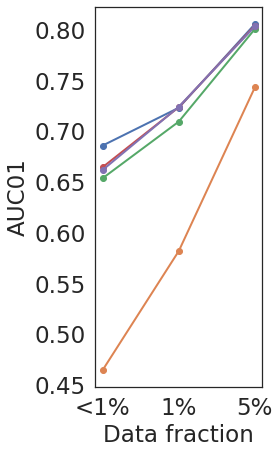

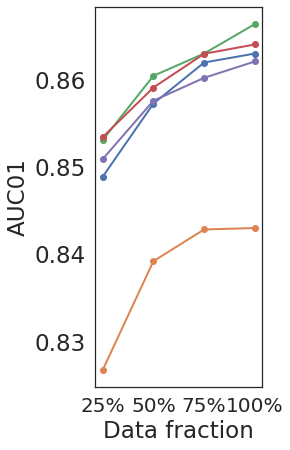

In [291]:
emb4_auc01 = auc_01[1]
emb20_auc01 = auc_01[2]
emb32_auc01 = auc_01[3]
emb64_auc01 = auc_01[4]
blosum50_auc01= auc_01[0]


ss_1, ss_2 = 0, 3

data = {
        'portion': portion[ss_1:ss_2],
        'Emb-d4': [round(x,9) for x in emb4_auc01][ss_1:ss_2],
        'Emb-d20': [round(x,9) for x in emb20_auc01][ss_1:ss_2],
        'Emb-d32': [round(x,9) for x in emb32_auc01][ss_1:ss_2],
        'Emb-d64': [round(x,9) for x in emb64_auc01][ss_1:ss_2],
        'BLOSUM50': [round(x,9) for x in blosum50_auc01][ss_1:ss_2]
       }

df_3 = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=[3, 7])



ax.plot(df_3['portion'],df_3['BLOSUM50'], marker='o', linewidth=2, label='BLOSUM50')
ax.plot(df_3['portion'],df_3['Emb-d4'],marker='o', linewidth=2, label='Embedding-d4')
ax.plot(df_3['portion'],df_3['Emb-d20'],marker='o', linewidth=2, label='Embedding-d20')
ax.plot(df_3['portion'],df_3['Emb-d32'],marker='o', linewidth=2, label='Embedding-d32')
ax.plot(df_3['portion'],df_3['Emb-d64'],marker='o', linewidth=2, label='Embedding-d64')


plt.tick_params(axis='x', labelsize=23)
plt.tick_params(axis='y', labelsize=23)

plt.xlabel('Data fraction', fontsize=23)
plt.ylabel('AUC01', fontsize=23)
#plt.legend(fontsize=20)
sn.set(style='white')
plt.show()



emb4_auc01 = auc_01[1]
emb20_auc01 = auc_01[2]
emb32_auc01 = auc_01[3]
emb64_auc01 = auc_01[4]
blosum50_auc01= auc_01[0]

ss_1, ss_2 = 3, 7

data = {
        'portion': portion[ss_1:ss_2],
        'Emb-d4': [round(x,9) for x in emb4_auc01][ss_1:ss_2],
        'Emb-d20': [round(x,9) for x in emb20_auc01][ss_1:ss_2],
        'Emb-d32': [round(x,9) for x in emb32_auc01][ss_1:ss_2],
        'Emb-d64': [round(x,9) for x in emb64_auc01][ss_1:ss_2],
        'BLOSUM50': [round(x,9) for x in blosum50_auc01][ss_1:ss_2]
       }

df_3 = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=[3, 7])

ax.plot(df_3['portion'],df_3['BLOSUM50'], marker='o', linewidth=2, label='BLOSUM50')
ax.plot(df_3['portion'],df_3['Emb-d4'],marker='o', linewidth=2, label='Embedding-d4')
ax.plot(df_3['portion'],df_3['Emb-d20'],marker='o', linewidth=2, label='Embedding-d20')
ax.plot(df_3['portion'],df_3['Emb-d32'],marker='o', linewidth=2, label='Embedding-d32')
ax.plot(df_3['portion'],df_3['Emb-d64'],marker='o', linewidth=2, label='Embedding-d64')

#ax.set(ylim=(0.845, 0.875))

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=23)

plt.xlabel('Data fraction', fontsize=23)
plt.ylabel('AUC01', fontsize=23)
#plt.legend(fontsize=20)
sn.set(style='white')
plt.show()


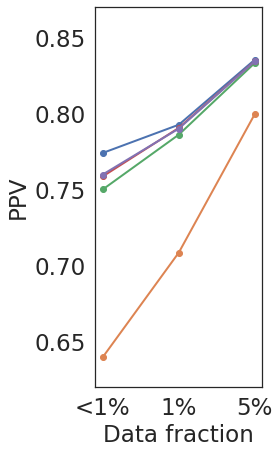

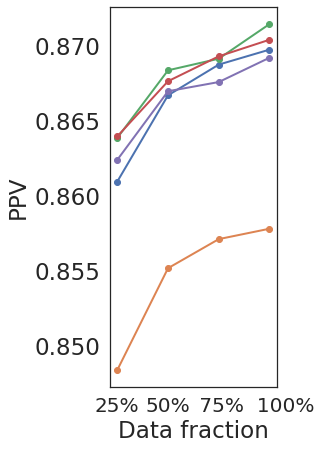

In [282]:
emb4_auc01 = ppv[1]
emb20_auc01 = ppv[2]
emb32_auc01 = ppv[3]
emb64_auc01 = ppv[4]
blosum50_auc01= ppv[0]

ss_1, ss_2 = 0, 3

data = {
        'portion': portion[ss_1:ss_2],
        'Emb-d4': [round(x,9) for x in emb4_auc01][ss_1:ss_2],
        'Emb-d20': [round(x,9) for x in emb20_auc01][ss_1:ss_2],
        'Emb-d32': [round(x,9) for x in emb32_auc01][ss_1:ss_2],
        'Emb-d64': [round(x,9) for x in emb64_auc01][ss_1:ss_2],
        'BLOSUM50': [round(x,9) for x in blosum50_auc01][ss_1:ss_2]
       }

df_3 = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=[3, 7])



ax.plot(df_3['portion'],df_3['BLOSUM50'], marker='o', linewidth=2, label='BLOSUM50')
ax.plot(df_3['portion'],df_3['Emb-d4'],marker='o', linewidth=2, label='Embedding-d4')
ax.plot(df_3['portion'],df_3['Emb-d20'],marker='o', linewidth=2, label='Embedding-d20')
ax.plot(df_3['portion'],df_3['Emb-d32'],marker='o', linewidth=2, label='Embedding-d32')
ax.plot(df_3['portion'],df_3['Emb-d64'],marker='o', linewidth=2, label='Embedding-d64')

ax.set(ylim=(0.62, 0.87))

plt.tick_params(axis='x', labelsize=23)
plt.tick_params(axis='y', labelsize=23)

plt.xlabel('Data fraction', fontsize=23)
plt.ylabel('PPV', fontsize=23)
#plt.legend(fontsize=20)
sn.set(style='white')
plt.show()



emb4_auc01 = ppv[1]
emb20_auc01 = ppv[2]
emb32_auc01 = ppv[3]
emb64_auc01 = ppv[4]
blosum50_auc01= ppv[0]

ss_1, ss_2 = 3, 7

data = {
        'portion': portion[ss_1:ss_2],
        'Emb-d4': [round(x,9) for x in emb4_auc01][ss_1:ss_2],
        'Emb-d20': [round(x,9) for x in emb20_auc01][ss_1:ss_2],
        'Emb-d32': [round(x,9) for x in emb32_auc01][ss_1:ss_2],
        'Emb-d64': [round(x,9) for x in emb64_auc01][ss_1:ss_2],
        'BLOSUM50': [round(x,9) for x in blosum50_auc01][ss_1:ss_2]
       }

df_3 = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=[3, 7])

ax.plot(df_3['portion'],df_3['BLOSUM50'], marker='o', linewidth=2, label='BLOSUM50')
ax.plot(df_3['portion'],df_3['Emb-d4'],marker='o', linewidth=2, label='Embedding-d4')
ax.plot(df_3['portion'],df_3['Emb-d20'],marker='o', linewidth=2, label='Embedding-d20')
ax.plot(df_3['portion'],df_3['Emb-d32'],marker='o', linewidth=2, label='Embedding-d32')
ax.plot(df_3['portion'],df_3['Emb-d64'],marker='o', linewidth=2, label='Embedding-d64')

#ax.set(ylim=(0.845, 0.875))

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=23)

plt.xlabel('Data fraction', fontsize=23)
plt.ylabel('PPV', fontsize=23)
#plt.legend(fontsize=20)
sn.set(style='white')
plt.show()


In [161]:
emb4_auc01 = auc_[1]
emb20_auc01 = auc_[2]
emb32_auc01 = auc_[3]
emb64_auc01 = auc_[4]
blosum50_auc01= auc_[0]

tt = 4

data = {
        'portion': portion,
        'Emb-d4': [round(x,tt) for x in emb4_auc01],
        'Emb-d20': [round(x,tt) for x in emb20_auc01],
        'Emb-d32': [round(x,tt) for x in emb32_auc01],
        'Emb-d64': [round(x,tt) for x in emb64_auc01],
        'BLOSUM50': [round(x,tt) for x in blosum50_auc01]
       }

df_3 = pd.DataFrame(data)
df_3.T

,0,1,2,3,4,5,6
portion,<1%,1%,5%,25%,50%,75%,100%
Emb-d4,0.8883,0.924,0.9597,0.9748,0.9766,0.9771,0.9773
Emb-d20,0.9397,0.9526,0.9705,0.9792,0.9801,0.9805,0.981
Emb-d32,0.9434,0.9558,0.9711,0.9792,0.98,0.9805,0.9806
Emb-d64,0.9435,0.9559,0.9707,0.9788,0.9797,0.9801,0.9804
BLOSUM50,0.9469,0.9552,0.9709,0.9784,0.9795,0.9803,0.9805


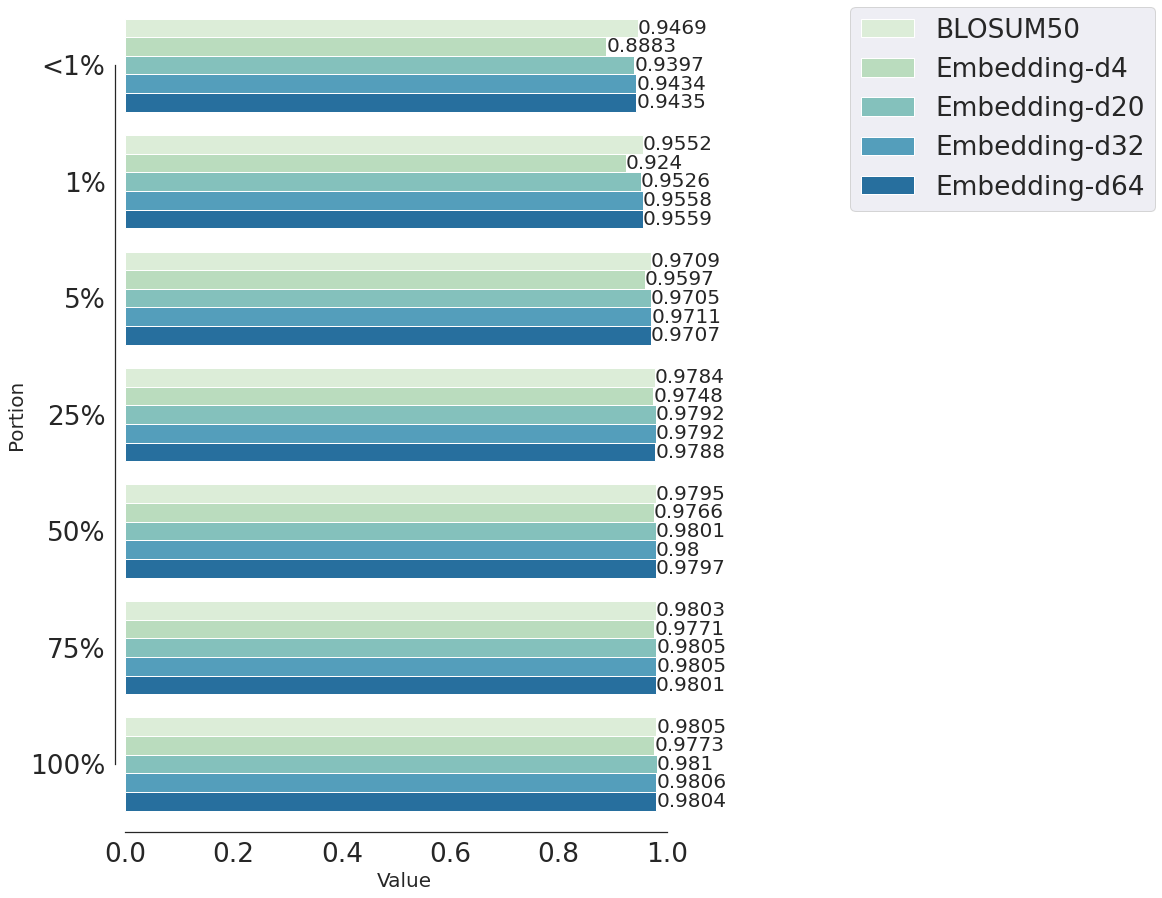

In [163]:
type_ = ['BLOSUM50', 'Embedding-d4', 'Embedding-d20', 'Embedding-d32', 'Embedding-d64']
portion = ['<1%', '1%', '5%', '25%', '50%', '75%', '100%']
df_list = []

for i,t in zip(auc_, type_):
    df_temp = pd.DataFrame({
        'Portion': portion,
        'Type': [t]*len(i),
        'Value': [round(x,4) for x in i]
    }
    )
    df_list.append(df_temp)
    
fig, ax = plt.subplots(figsize=(10,15))
    
sn.barplot(x='Value', y='Portion', hue='Type', data=df_3, palette='GnBu')

sn.set(style='white')

for container in ax.containers:
    ax.bar_label(container, size=20)
    
for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=23)
    plt.setp(ax.get_legend().get_title(), fontsize=28)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=20)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=20)

sn.set(font_scale=2.4)

sn.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.3, 1),
           borderaxespad=0)
sn.set(style='white')

plt.show()

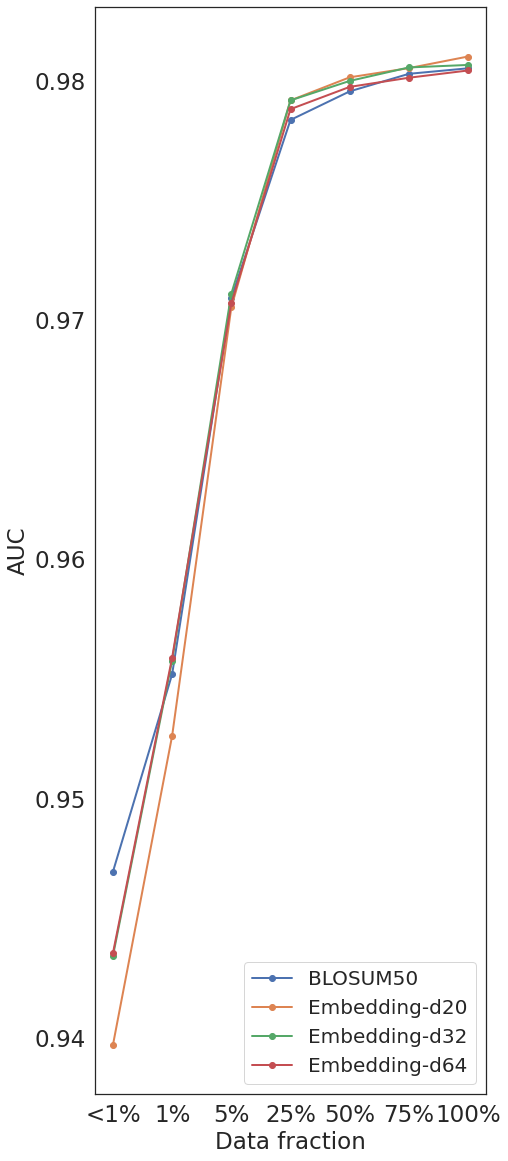

In [164]:
emb4_auc01 = auc_[1]
emb20_auc01 = auc_[2]
emb32_auc01 = auc_[3]
emb64_auc01 = auc_[4]
blosum50_auc01= auc_[0]
portion = ['<1%', '1%', '5%', '25%', '50%', '75%', '100%']

data = {
        'portion': portion,
        'Emb-d4': emb4_auc01,
        'Emb-d20': emb20_auc01,
        'Emb-d32': emb32_auc01,
        'Emb-d64': emb64_auc01,
        'BLOSUM50': blosum50_auc01
       }

df_3 = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=[7, 20])

ax.plot(df_3['portion'],df_3['BLOSUM50'], marker='o', linewidth=2, label='BLOSUM50')
ax.plot(df_3['portion'],df_3['Emb-d20'],marker='o', linewidth=2, label='Embedding-d20')
ax.plot(df_3['portion'],df_3['Emb-d32'],marker='o', linewidth=2, label='Embedding-d32')
ax.plot(df_3['portion'],df_3['Emb-d64'],marker='o', linewidth=2, label='Embedding-d64')

#plt.xticks(rotation=20)
plt.tick_params(axis='x', labelsize=23)
plt.tick_params(axis='y', labelsize=23)

plt.xlabel('Data fraction', fontsize=23)
plt.ylabel('AUC', fontsize=23)
plt.legend(fontsize=20)
sn.set(style='white')
plt.show()


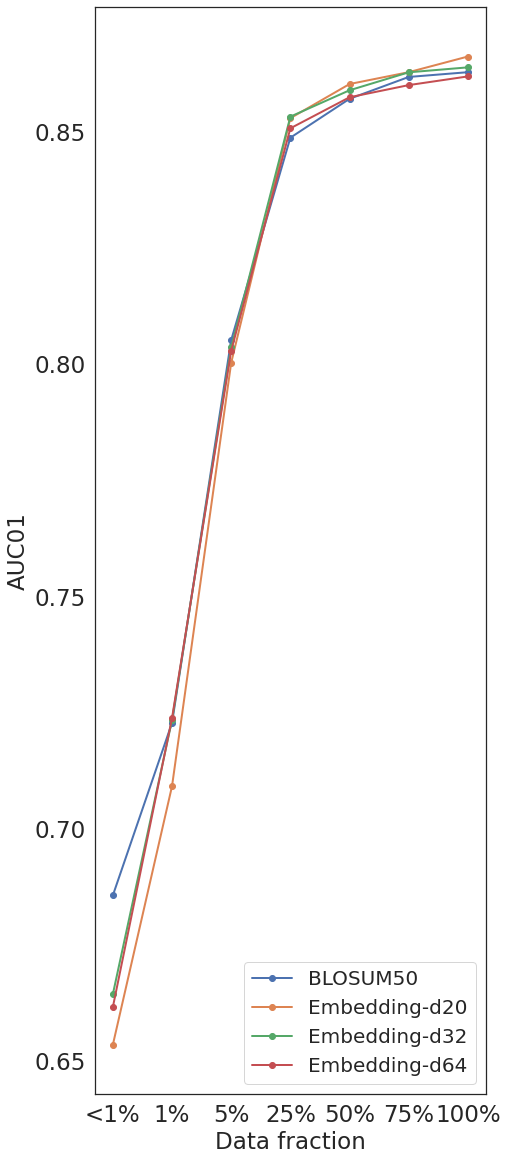

In [167]:
emb4_auc01 = auc_01[1]
emb20_auc01 = auc_01[2]
emb32_auc01 = auc_01[3]
emb64_auc01 = auc_01[4]
blosum50_auc01= auc_01[0]
portion = ['<1%', '1%', '5%', '25%', '50%', '75%', '100%']

TT = 9
data = {
        'portion': portion,
        'Emb-d4': [round(x,TT) for x in emb4_auc01],
        'Emb-d20': [round(x,TT) for x in emb20_auc01],
        'Emb-d32': [round(x,TT) for x in emb32_auc01],
        'Emb-d64': [round(x,TT) for x in emb64_auc01],
        'BLOSUM50': [round(x,TT) for x in blosum50_auc01]
       }

df_3 = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=[7, 20])

ax.plot(df_3['portion'],df_3['BLOSUM50'], marker='o', linewidth=2, label='BLOSUM50')
ax.plot(df_3['portion'],df_3['Emb-d20'],marker='o', linewidth=2, label='Embedding-d20')
ax.plot(df_3['portion'],df_3['Emb-d32'],marker='o', linewidth=2, label='Embedding-d32')
ax.plot(df_3['portion'],df_3['Emb-d64'],marker='o', linewidth=2, label='Embedding-d64')

#plt.xticks(rotation=20)
plt.tick_params(axis='x', labelsize=23)
plt.tick_params(axis='y', labelsize=23)

plt.xlabel('Data fraction', fontsize=23)
plt.ylabel('AUC01', fontsize=23)
plt.legend(fontsize=20)
sn.set(style='white')
plt.show()


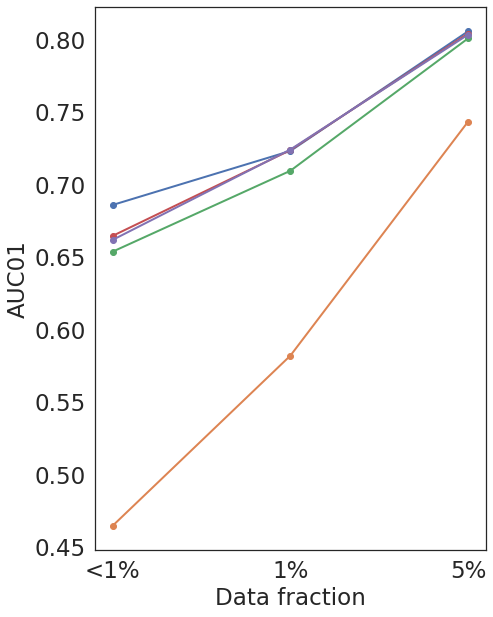

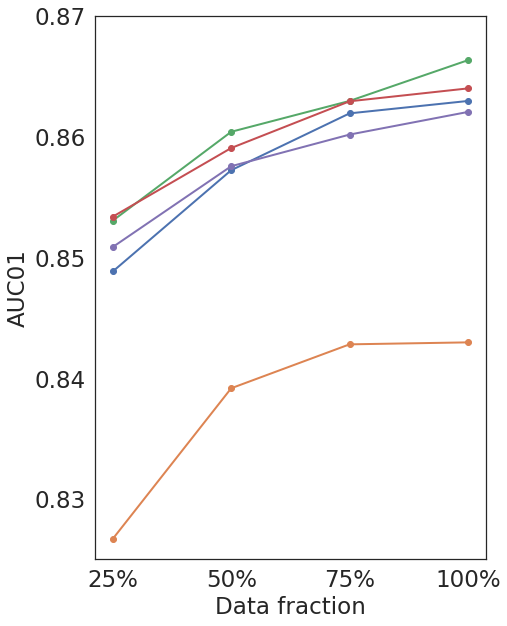

In [210]:
emb4_auc01 = auc_01[1]
emb20_auc01 = auc_01[2]
emb32_auc01 = auc_01[3]
emb64_auc01 = auc_01[4]
blosum50_auc01= auc_01[0]
portion = ['<1%', '1%', '5%', '25%', '50%', '75%', '100%']

ss_1, ss_2 = 0, 3

data = {
        'portion': portion[ss_1:ss_2],
        'Emb-d4': [round(x,9) for x in emb4_auc01][ss_1:ss_2],
        'Emb-d20': [round(x,9) for x in emb20_auc01][ss_1:ss_2],
        'Emb-d32': [round(x,9) for x in emb32_auc01][ss_1:ss_2],
        'Emb-d64': [round(x,9) for x in emb64_auc01][ss_1:ss_2],
        'BLOSUM50': [round(x,9) for x in blosum50_auc01][ss_1:ss_2]
       }

df_3 = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=[7, 10])

ax.plot(df_3['portion'],df_3['BLOSUM50'], marker='o', linewidth=2, label='BLOSUM50')
ax.plot(df_3['portion'],df_3['Emb-d4'],marker='o', linewidth=2, label='Embedding-d4')
ax.plot(df_3['portion'],df_3['Emb-d20'],marker='o', linewidth=2, label='Embedding-d20')
ax.plot(df_3['portion'],df_3['Emb-d32'],marker='o', linewidth=2, label='Embedding-d32')
ax.plot(df_3['portion'],df_3['Emb-d64'],marker='o', linewidth=2, label='Embedding-d64')

plt.tick_params(axis='x', labelsize=23)
plt.tick_params(axis='y', labelsize=23)

plt.xlabel('Data fraction', fontsize=23)
plt.ylabel('AUC01', fontsize=23)
#plt.legend(fontsize=20)
sn.set(style='white')
plt.show()



emb4_auc01 = auc_01[1]
emb20_auc01 = auc_01[2]
emb32_auc01 = auc_01[3]
emb64_auc01 = auc_01[4]
blosum50_auc01= auc_01[0]
portion = ['<1%', '1%', '5%', '25%', '50%', '75%', '100%']

ss_1, ss_2 = 3, 7

data = {
        'portion': portion[ss_1:ss_2],
        'Emb-d4': [round(x,9) for x in emb4_auc01][ss_1:ss_2],
        'Emb-d20': [round(x,9) for x in emb20_auc01][ss_1:ss_2],
        'Emb-d32': [round(x,9) for x in emb32_auc01][ss_1:ss_2],
        'Emb-d64': [round(x,9) for x in emb64_auc01][ss_1:ss_2],
        'BLOSUM50': [round(x,9) for x in blosum50_auc01][ss_1:ss_2]
       }

df_3 = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=[7, 10])

ax.plot(df_3['portion'],df_3['BLOSUM50'], marker='o', linewidth=2, label='BLOSUM50')
ax.plot(df_3['portion'],df_3['Emb-d4'],marker='o', linewidth=2, label='Embedding-d4')
ax.plot(df_3['portion'],df_3['Emb-d20'],marker='o', linewidth=2, label='Embedding-d20')
ax.plot(df_3['portion'],df_3['Emb-d32'],marker='o', linewidth=2, label='Embedding-d32')
ax.plot(df_3['portion'],df_3['Emb-d64'],marker='o', linewidth=2, label='Embedding-d64')

ax.set(ylim=(0.825, 0.87))

plt.tick_params(axis='x', labelsize=23)
plt.tick_params(axis='y', labelsize=23)

plt.xlabel('Data fraction', fontsize=23)
plt.ylabel('AUC01', fontsize=23)
#plt.legend(fontsize=20)
sn.set(style='white')
plt.show()




## BINOMIAL TEST BLOSUM VERSUS EMBEDDING - BASELINE - ATTN

In [28]:
d_model_list = [4, 20, 32, 64]

metric = 'PPV'
print(metric)

df_list_emb = []
merged_list = []
df_list = []
df_tag_list = []
bin_list = []

emb_ins_list = []

for size in ['05p', '1p', '5p', '25p', '50p', '75p', '100p']:
    
    #if size == '1p':
    #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0'.format(size, 'onlyBlosum')
    #    id_emb = 'OF_TData_pad14_{}_{}_downsample0'.format(size, 'onlyEmbedding')
        
    #elif size == '05p':
    #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0_125ep'.format(size, 'onlyBlosum')
    #    id_emb = 'OF_TData_pad14_{}_{}_downsample0_125ep'.format(size, 'onlyEmbedding')
        
    #if size == '25p':
    #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOSSH'.format(size, 'onlyBlosum') ##sh
    #    id_emb = 'OF_TData_pad14_{}_{}_NOPOSSH'.format(size, 'onlyEmbedding') ##sh
      
    id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
    id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')
    
    if size in ['75p', '100p']:
        id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
        
    df_name = '{}_d{}_HLAperf.csv'.format(id_blosum,20)
    
    #print(df_name[53::])
    temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)#[['HLA','{}'.format(metric)]]
    
    if size == '05p':
        s = '<1%'
    else:
        s = size.replace('p', '%')
    temp_1['Data fraction'] = s
    temp_1['Method'] = 'BLOSUM'.format(20)
    temp_1['Tag'] = 'BLOSUM'
    
    df_list.append(temp_1)
    tag_1 = size + '_onlyBlosum' + '_d20'
    #print(tag_1, 'added.')
    
    for d_model in d_model_list:
        
        
        id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')
        
        if size in ['75p', '100p']:
            id_emb = 'OF_TData_pad14_{}_{}_NOPOS'.format(size, 'onlyEmbedding')
            
        if d_model in [20, 32] and size =='50p':
            id_emb = 'OF_TData_pad14_{}_{}_NOPOS'.format(size, 'onlyEmbedding')
            
        #if size =='25p':
        #    id_emb = 'OF_TData_pad14_{}_{}_NOPOSSH'.format(size, 'onlyEmbedding')
            
        if size =='100p':
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')
            
        df_name = '{}_d{}_HLAperf.csv'.format(id_emb, d_model)

        temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2['Data fraction'] = s
        temp_2['Method'] = 'Embedding'.format(d_model)
        temp_2['Tag'] = 'Embedding_d{}'.format(d_model)
        
        df_list.append(temp_2)
        df_list_emb.append(temp_2)
        emb_ins_list.append(temp_2)
        tag_2 = size + '_onlyEmbedding_d' + str(d_model)
        #print(tag_2, 'added.')
        
        merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])
        
        equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

        first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

        pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

        bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]]) 
        print(bin_)
        merged['type'] = tag_1 + " vs " + tag_2
        merged_list.append(merged)
        
    print(".")
    
print([tag_1+" vs "+tag_2, size, 'emb_wins', 'blosum_wins', pval])

PPV
05p 05p_onlyBlosum_d20: 110 | Equal:1 | 05p_onlyEmbedding_d4: 1 | 4.3140830754274083e-32
05p 05p_onlyBlosum_d20: 83 | Equal:4 | 05p_onlyEmbedding_d20: 25 | 9.414669009536399e-09
05p 05p_onlyBlosum_d20: 70 | Equal:1 | 05p_onlyEmbedding_d32: 41 | 0.0037924058877158093
05p 05p_onlyBlosum_d20: 68 | Equal:3 | 05p_onlyEmbedding_d64: 41 | 0.006201818621664985
.
1p 1p_onlyBlosum_d20: 108 | Equal:1 | 1p_onlyEmbedding_d4: 3 | 8.783473141570203e-29
1p 1p_onlyBlosum_d20: 71 | Equal:1 | 1p_onlyEmbedding_d20: 40 | 0.0020977670926974304
1p 1p_onlyBlosum_d20: 60 | Equal:8 | 1p_onlyEmbedding_d32: 44 | 0.07047814410615424
1p 1p_onlyBlosum_d20: 56 | Equal:8 | 1p_onlyEmbedding_d64: 48 | 0.24632253324325118
.
5p 5p_onlyBlosum_d20: 104 | Equal:4 | 5p_onlyEmbedding_d4: 4 | 1.7161231421799747e-26
5p 5p_onlyBlosum_d20: 57 | Equal:5 | 5p_onlyEmbedding_d20: 50 | 0.28104634252689503
5p 5p_onlyBlosum_d20: 47 | Equal:8 | 5p_onlyEmbedding_d32: 57 | 0.8596548354829103
5p 5p_onlyBlosum_d20: 51 | Equal:8 | 5p_onlyE

In [38]:
d_model_list = [4, 20, 32, 64]

metric = 'AUC01'
print(metric)

merged_list = []
df_list = []
median_list_emb = []
mean_list_emb = []
df_list_emb = []

median_list_bl_emb = []
mean_list_bl_emb = []
df_list_bl_emb = []
df_tag_list = []
bin_list = []
mean_list = []
median_list = []

size_list = ['05p', '1p', '25p', '75p', '100p']
d_model_list = [4,20,32,64]

merged_list = []
df_list = []
df_tag_list = []
bin_list = []

emb_ins_list = []
for size in size_list: 

    
    if size == '1p':
        id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
        id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
    elif size == '05p':
        id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
        id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
    else:
        id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'.format(size, 'Blosum_ED')
        id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'EmbeddingAttention')
        
    df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_blosum,20)
    temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)#[['HLA','{}'.format(metric)]]
   
    if size == '05p':
        s = '<1%'
    else:
        s = size.replace('p', '%')
        
    temp_1['Datafraction'] = s
    temp_1['Method'] = 'BLOSUM-Attention'.format(20)
    temp_1['Tag'] = 'BLOSUM'
    df_list.append(temp_1)
    
    # ----
    md = np.median(list(temp_1[metric]))
    me = np.mean(list(temp_1[metric]))
    median_list.append(md)
    mean_list.append(me)
    median_list_bl_emb.append(md)
    mean_list_bl_emb.append(me)
    df_list_bl_emb.append(temp_1)
    df_list.append(temp_1)
    # ----
    
    tag_1 = size + 'BLOSUM-Attention' + '_d20'
    print(tag_1, 'added.')
    
    for d_model in d_model_list:
        
        df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_emb,d_model)
        
        temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2['Datafraction'] = s
        temp_2['Method'] = 'Embedding-Attention-d{}'.format(d_model)
        df_list.append(temp_2)
        tag_2 = size + 'Embedding-Attention-d' + str(d_model)
        
        md = np.median(list(temp_2[metric]))
        me = np.mean(list(temp_2[metric]))
        
        # ----
        temp_2_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2_bl_em['Datafraction'] = s
        temp_2_bl_em['Method'] = 'Embedding-Attention'.format(d_model)
        temp_2['Tag'] = 'LE-d{}'.format(d_model)
        
        if size+str(d_model) in ['05p20', '1p20', '25p32', '75p64', '100p64']: #32 64 32 32 20 20 20
            df_list_bl_emb.append(temp_2_bl_em)
            median_list_bl_emb.append(md)
            mean_list_bl_emb.append(me)
        
        median_list.append(md)
        mean_list.append(me)
        mean_list_emb.append(me)
        median_list_emb.append(md)
        df_list_emb.append(temp_2)
        emb_ins_list.append(temp_2)
        # ----
        
        merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

        equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

        first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

        pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

        bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]])
        #df_temp = pd.DataFrame(bin_, columns = [size])
        print(bin_)
        
        md = np.median(list(temp_2[metric]))
        me = np.mean(list(temp_2[metric]))
        median_list.append(md)
        mean_list.append(me)
        
        merged['Method'] = tag_1 + " vs " + tag_2
        merged_list.append(merged)
        #bin_list.append(pd.DataFrame(bin_, columns = [size]))
        
print(metric)  

df_concat_o = pd.concat(df_list)



AUC01
05pBLOSUM-Attention_d20 added.
05p 05pBLOSUM-Attention_d20: 112 | Equal:0 | 05pEmbedding-Attention-d4: 0 | 1.925929944387236e-34
05p 05pBLOSUM-Attention_d20: 80 | Equal:0 | 05pEmbedding-Attention-d20: 32 | 3.2831696769131175e-06
05p 05pBLOSUM-Attention_d20: 97 | Equal:0 | 05pEmbedding-Attention-d32: 15 | 3.560930165143116e-16
05p 05pBLOSUM-Attention_d20: 91 | Equal:0 | 05pEmbedding-Attention-d64: 21 | 7.09930540827549e-12
1pBLOSUM-Attention_d20 added.
1p 1pBLOSUM-Attention_d20: 112 | Equal:0 | 1pEmbedding-Attention-d4: 0 | 1.925929944387236e-34
1p 1pBLOSUM-Attention_d20: 92 | Equal:0 | 1pEmbedding-Attention-d20: 20 | 1.5940428279271969e-12
1p 1pBLOSUM-Attention_d20: 98 | Equal:0 | 1pEmbedding-Attention-d32: 14 | 5.3779798361241724e-17
1p 1pBLOSUM-Attention_d20: 98 | Equal:0 | 1pEmbedding-Attention-d64: 14 | 5.3779798361241724e-17
25pBLOSUM-Attention_d20 added.
25p 25pBLOSUM-Attention_d20: 110 | Equal:0 | 25pEmbedding-Attention-d4: 2 | 1.2189210618026816e-30
25p 25pBLOSUM-Attentio

## BINOMIAL TEST - COMPARISON OF DIFFERENT EMBEDDINGS - ATTENTION

In [54]:
edconcat = []

for metric in ['AUC01']:


    # splitted june 17

    # JUN 17 BOX BASE
    # NOPOS BIN

    d_model_list = [4, 20, 32, 64]

    print(metric)

    merged_list = []
    df_list = []
    median_list_emb = []
    mean_list_emb = []
    df_list_emb = []

    median_list_bl_emb = []
    mean_list_bl_emb = []
    df_list_bl_emb = []
    df_tag_list = []
    bin_list = []
    mean_list = []
    median_list = []

    size_list = ['05p', '1p', '25p', '75p', '100p']
    d_model_list = [4,20,32,64]

    merged_list = []
    df_list = []
    df_tag_list = []
    bin_list = []

    emb_ins_list = []
    for size in size_list: 


        if size == '1p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
        elif size == '05p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
        else:
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'EmbeddingAttention')

        df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_blosum,20)
        temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)#[['HLA','{}'.format(metric)]]

        if size == '05p':
            s = '<1%'
        else:
            s = size.replace('p', '%')

        temp_1['Datafraction'] = s
        temp_1['Method'] = 'BLOSUM-Attention'.format(20)
        temp_1['Tag'] = 'BLOSUM'
        df_list.append(temp_1)

        # ----
        md = np.median(list(temp_1[metric]))
        me = np.mean(list(temp_1[metric]))
        median_list.append(md)
        mean_list.append(me)
        median_list_bl_emb.append(md)
        mean_list_bl_emb.append(me)
        df_list_bl_emb.append(temp_1)
        df_list.append(temp_1)
        # ----

        tag_1 = size + 'BLOSUM-Attention' + '_d20'
        print(tag_1, 'added.')

        for d_model in d_model_list:

            df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_emb,d_model)

            temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2['Datafraction'] = s
            temp_2['Method'] = 'Embedding-Attention-d{}'.format(d_model)
            df_list.append(temp_2)
            tag_2 = size + 'Embedding-Attention-d' + str(d_model)

            md = np.median(list(temp_2[metric]))
            me = np.mean(list(temp_2[metric]))

            # ----
            temp_2_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2_bl_em['Datafraction'] = s
            temp_2_bl_em['Method'] = 'Embedding-Attention'.format(d_model)
            temp_2['Tag'] = 'LE-d{}'.format(d_model)

            if size+str(d_model) in ['05p20', '1p20', '25p32', '75p64', '100p64']: #32 64 32 32 20 20 20
                df_list_bl_emb.append(temp_2_bl_em)
                median_list_bl_emb.append(md)
                mean_list_bl_emb.append(me)

            median_list.append(md)
            mean_list.append(me)
            mean_list_emb.append(me)
            median_list_emb.append(md)
            df_list_emb.append(temp_2)
            emb_ins_list.append(temp_2)
            # ----

            merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

            equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

            first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

            pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

            bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]])
            #df_temp = pd.DataFrame(bin_, columns = [size])
            print(bin_)

            md = np.median(list(temp_2[metric]))
            me = np.mean(list(temp_2[metric]))
            median_list.append(md)
            mean_list.append(me)

            merged['Method'] = tag_1 + " vs " + tag_2
            merged_list.append(merged)
            
            #bin_list.append(pd.DataFrame(bin_, columns = [size]))

    print(metric)  

    df_concat_o = pd.concat(df_list)
    # June 17

    # EMB INS

    d_model_list = [4, 20, 32, 64]

    metric = 'AUC01'
    print(metric)

    size_cl = list(range(5))

    portion = ['<1%', '1%', '25%', '75%', '100%']

    for size_c in size_cl:

        comp_in_size = []

        ppp = portion[size_c]

        for idx_1 in range(4):

            d_model_1 = d_model_list[idx_1]

            temp_1 = emb_ins_list[idx_1 + (4*size_c)]

            tag_1 = list(temp_1.Tag)[0]

            size = list(temp_1['Datafraction'])[0]

            print(idx_1 + (4*size_c), size)
            print(tag_1)

            comp_in_size_temp = []

            for idx_2 in range(4):

                d_model_2 = d_model_list[idx_2]

                temp_2 = emb_ins_list[idx_2 + (4*size_c)]
                tag_2 = list(temp_2.Tag)[0]
                size = list(temp_2['Datafraction'])[0]

                merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

                equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

                first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

                pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

                bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]] )
                print("\t\t", bin_)
                if 'e' in str(pval):
                    pval = str(float('{:0.3e}'.format(pval)))
                else:
                    pval = str(round(pval,3))

                if 1 == pval:
                    pval = '1.0'

                comp_in_size_temp.append(pval)


            comp_in_size.append(comp_in_size_temp)

        comp_size_df = pd.DataFrame(comp_in_size).T
        comp_size_df.columns = ['dim ' + str(x) for x in d_model_list]
        comp_size_df.index = ['dim ' + str(x) for x in d_model_list]
        #comp_size_df.index.name = 'df: {}'.format(ppp)
        display(comp_size_df)
        print(comp_size_df.to_latex())
        
        edconcat.append(comp_size_df)

        print("-------")



AUC01
05pBLOSUM-Attention_d20 added.
05p 05pBLOSUM-Attention_d20: 112 | Equal:0 | 05pEmbedding-Attention-d4: 0 | 1.925929944387236e-34
05p 05pBLOSUM-Attention_d20: 80 | Equal:0 | 05pEmbedding-Attention-d20: 32 | 3.2831696769131175e-06
05p 05pBLOSUM-Attention_d20: 97 | Equal:0 | 05pEmbedding-Attention-d32: 15 | 3.560930165143116e-16
05p 05pBLOSUM-Attention_d20: 91 | Equal:0 | 05pEmbedding-Attention-d64: 21 | 7.09930540827549e-12
1pBLOSUM-Attention_d20 added.
1p 1pBLOSUM-Attention_d20: 112 | Equal:0 | 1pEmbedding-Attention-d4: 0 | 1.925929944387236e-34
1p 1pBLOSUM-Attention_d20: 92 | Equal:0 | 1pEmbedding-Attention-d20: 20 | 1.5940428279271969e-12
1p 1pBLOSUM-Attention_d20: 98 | Equal:0 | 1pEmbedding-Attention-d32: 14 | 5.3779798361241724e-17
1p 1pBLOSUM-Attention_d20: 98 | Equal:0 | 1pEmbedding-Attention-d64: 14 | 5.3779798361241724e-17
25pBLOSUM-Attention_d20 added.
25p 25pBLOSUM-Attention_d20: 110 | Equal:0 | 25pEmbedding-Attention-d4: 2 | 1.2189210618026816e-30
25p 25pBLOSUM-Attentio

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,2.176e-32,1.219e-30,2.176e-32
dim 20,1.0,1.0,1.0,1.0
dim 32,1.0,6.716e-14,1.0,0.682
dim 64,1.0,1.19e-10,0.388,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  2.176e-32 &  1.219e-30 &  2.176e-32 \\
dim 20 &   1.0 &        1.0 &        1.0 &        1.0 \\
dim 32 &   1.0 &  6.716e-14 &        1.0 &      0.682 \\
dim 64 &   1.0 &   1.19e-10 &      0.388 &        1.0 \\
\bottomrule
\end{tabular}

-------
4 1%
LE-d4
		 1% LE-d4: 0 | Equal:112 | LE-d4: 0 | 1.0
		 1% LE-d4: 0 | Equal:0 | LE-d20: 112 | 1.0
		 1% LE-d4: 1 | Equal:0 | LE-d32: 111 | 1.0
		 1% LE-d4: 1 | Equal:0 | LE-d64: 111 | 1.0
5 1%
LE-d20
		 1% LE-d20: 112 | Equal:0 | LE-d4: 0 | 1.925929944387236e-34
		 1% LE-d20: 0 | Equal:112 | LE-d20: 0 | 1.0
		 1% LE-d20: 90 | Equal:0 | LE-d32: 22 | 2.987107335426161e-11
		 1% LE-d20: 96 | Equal:0 | LE-d64: 16 | 2.188866901567298e-15
6 1%
LE-d32
		 1% LE-d32: 111 | Equal:0 | LE-d4: 1 | 2.1763008371575765e-32
		 1% LE-d32: 22 | Equal:0 | LE-d20: 90 | 0.9999999999929007
		 1% LE-d32: 0 | Equal:112 | LE-d32: 0 | 1.0
		 1% LE-d32: 75 | Eq

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.926e-34,2.176e-32,2.176e-32
dim 20,1.0,1.0,1.0,1.0
dim 32,1.0,2.987e-11,1.0,1.0
dim 64,1.0,2.189e-15,0.0,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  1.926e-34 &  2.176e-32 &  2.176e-32 \\
dim 20 &   1.0 &        1.0 &        1.0 &        1.0 \\
dim 32 &   1.0 &  2.987e-11 &        1.0 &        1.0 \\
dim 64 &   1.0 &  2.189e-15 &        0.0 &        1.0 \\
\bottomrule
\end{tabular}

-------
8 25%
LE-d4
		 25% LE-d4: 0 | Equal:112 | LE-d4: 0 | 1.0
		 25% LE-d4: 4 | Equal:0 | LE-d20: 108 | 1.0
		 25% LE-d4: 2 | Equal:0 | LE-d32: 110 | 1.0
		 25% LE-d4: 6 | Equal:0 | LE-d64: 106 | 1.0
9 25%
LE-d20
		 25% LE-d20: 108 | Equal:0 | LE-d4: 4 | 1.2412751380741896e-27
		 25% LE-d20: 0 | Equal:112 | LE-d20: 0 | 1.0
		 25% LE-d20: 59 | Equal:0 | LE-d32: 53 | 0.31839988580711653
		 25% LE-d20: 64 | Equal:0 | LE-d64: 48 | 0.07803315099688383
10 25%
LE-d32
		 25% LE-d32: 110 | Equal:0 | LE-d4: 2 | 1.2189210618026816e-30
		 25% LE-d32: 53 | Equal:0 | LE-d20: 59 | 0.7457434100131688
		 25% LE-d32: 0 | Equal:112 | LE-d32: 0 | 1.0
		 25% LE

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.241e-27,1.219e-30,4.878e-25
dim 20,1.0,1.0,0.746,0.946
dim 32,1.0,0.318,1.0,0.851
dim 64,1.0,0.078,0.198,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  1.241e-27 &  1.219e-30 &  4.878e-25 \\
dim 20 &   1.0 &        1.0 &      0.746 &      0.946 \\
dim 32 &   1.0 &      0.318 &        1.0 &      0.851 \\
dim 64 &   1.0 &      0.078 &      0.198 &        1.0 \\
\bottomrule
\end{tabular}

-------
12 75%
LE-d4
		 75% LE-d4: 0 | Equal:112 | LE-d4: 0 | 1.0
		 75% LE-d4: 1 | Equal:0 | LE-d20: 111 | 1.0
		 75% LE-d4: 0 | Equal:0 | LE-d32: 112 | 1.0
		 75% LE-d4: 2 | Equal:0 | LE-d64: 110 | 1.0
13 75%
LE-d20
		 75% LE-d20: 111 | Equal:0 | LE-d4: 1 | 2.1763008371575765e-32
		 75% LE-d20: 0 | Equal:112 | LE-d20: 0 | 1.0
		 75% LE-d20: 32 | Equal:0 | LE-d32: 80 | 0.999998736124823
		 75% LE-d20: 33 | Equal:0 | LE-d64: 79 | 0.9999967168303231
14 75%
LE-d32
		 75% LE-d32: 112 | Equal:0 | LE-d4: 0 | 1.925929944387236e-34
		 75% LE-d32: 80 | Equal:0 | LE-d20: 32 | 3.2831696769131175e-06
		 75% LE-d32: 0 | Equal:112 | LE-d32: 0 | 1.0
		 75% 

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,2.176e-32,1.926e-34,1.219e-30
dim 20,1.0,1.0,3.283e-06,8.178e-06
dim 32,1.0,1.0,1.0,0.149
dim 64,1.0,1.0,0.89,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  2.176e-32 &  1.926e-34 &  1.219e-30 \\
dim 20 &   1.0 &        1.0 &  3.283e-06 &  8.178e-06 \\
dim 32 &   1.0 &        1.0 &        1.0 &      0.149 \\
dim 64 &   1.0 &        1.0 &       0.89 &        1.0 \\
\bottomrule
\end{tabular}

-------
16 100%
LE-d4
		 100% LE-d4: 0 | Equal:112 | LE-d4: 0 | 1.0
		 100% LE-d4: 1 | Equal:0 | LE-d20: 111 | 1.0
		 100% LE-d4: 1 | Equal:1 | LE-d32: 110 | 1.0
		 100% LE-d4: 0 | Equal:0 | LE-d64: 112 | 1.0
17 100%
LE-d20
		 100% LE-d20: 111 | Equal:0 | LE-d4: 1 | 2.1763008371575765e-32
		 100% LE-d20: 0 | Equal:112 | LE-d20: 0 | 1.0
		 100% LE-d20: 45 | Equal:0 | LE-d32: 67 | 0.9853488885141836
		 100% LE-d20: 29 | Equal:0 | LE-d64: 83 | 0.9999999444650023
18 100%
LE-d32
		 100% LE-d32: 110 | Equal:1 | LE-d4: 1 | 4.3140830754274083e-32
		 100% LE-d32: 67 | Equal:0 | LE-d20: 45 | 0.02336753409697996
		 100% LE-d32: 0 | Equal:112 | LE-d32: 0 

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,2.176e-32,4.314e-32,1.926e-34
dim 20,1.0,1.0,0.023,1.645e-07
dim 32,1.0,0.985,1.0,1.79e-08
dim 64,1.0,1.0,1.0,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  2.176e-32 &  4.314e-32 &  1.926e-34 \\
dim 20 &   1.0 &        1.0 &      0.023 &  1.645e-07 \\
dim 32 &   1.0 &      0.985 &        1.0 &   1.79e-08 \\
dim 64 &   1.0 &        1.0 &        1.0 &        1.0 \\
\bottomrule
\end{tabular}

-------


In [55]:
id_x = 0
d_model_list = [4, 20, 32, 64]

metric = 'PPV'

size_cl = list(range(5))

portion = ['<1%', '1%', '25%', '75%', '100%']

for size_c in size_cl:
    
    comp_in_size = []
    
    ppp = portion[size_c]
    
    for idx_1 in range(4):

        d_model_1 = d_model_list[idx_1]

        temp_1 = emb_ins_list[idx_1 + (4*size_c)]

        tag_1 = list(temp_1.Tag)[0]

        size = list(temp_1['Datafraction'])[0]

        print(idx_1 + (4*size_c), size)
        print(tag_1)
        
        comp_in_size_temp = []

        for idx_2 in range(4):

            d_model_2 = d_model_list[idx_2]

            temp_2 = emb_ins_list[idx_2 + (4*size_c)]
            tag_2 = list(temp_2.Tag)[0]
            size = list(temp_2['Datafraction'])[0]

            merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

            equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())
            
            first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

            pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

            bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]] )
            print("\t\t", bin_)
            if 'e' in str(pval):
                pval = str(float('{:0.3e}'.format(pval)))
            else:
                pval = str(round(pval,3))
                
            if 1 == pval:
                pval = '1.0'
                
            comp_in_size_temp.append(pval)
            
            
        comp_in_size.append(comp_in_size_temp)
        
    comp_size_df = pd.DataFrame(comp_in_size).T
    comp_size_df.columns = ['dim ' + str(x) for x in d_model_list]
    comp_size_df.index = ['dim ' + str(x) for x in d_model_list]
    #comp_size_df.index.name = 'df: {}'.format(ppp)
    display(comp_size_df)
    
    latex = pd.concat([edconcat[id_x], comp_size_df ],axis =1)
    print(latex.to_latex())
    print("-------")
    id_x += 1

    
    print("-------")


0 <1%
LE-d4
		 <1% LE-d4: 0 | Equal:112 | LE-d4: 0 | 1.0
		 <1% LE-d4: 1 | Equal:0 | LE-d20: 111 | 1.0
		 <1% LE-d4: 1 | Equal:0 | LE-d32: 111 | 1.0
		 <1% LE-d4: 0 | Equal:0 | LE-d64: 112 | 1.0
1 <1%
LE-d20
		 <1% LE-d20: 111 | Equal:0 | LE-d4: 1 | 2.1763008371575765e-32
		 <1% LE-d20: 0 | Equal:112 | LE-d20: 0 | 1.0
		 <1% LE-d20: 94 | Equal:3 | LE-d32: 15 | 1.853062068995287e-15
		 <1% LE-d20: 85 | Equal:5 | LE-d64: 22 | 3.187740825583467e-10
2 <1%
LE-d32
		 <1% LE-d32: 111 | Equal:0 | LE-d4: 1 | 2.1763008371575765e-32
		 <1% LE-d32: 15 | Equal:3 | LE-d20: 94 | 0.9999999999999997
		 <1% LE-d32: 0 | Equal:112 | LE-d32: 0 | 1.0
		 <1% LE-d32: 53 | Equal:1 | LE-d64: 58 | 0.7153898860982124
3 <1%
LE-d64
		 <1% LE-d64: 112 | Equal:0 | LE-d4: 0 | 1.925929944387236e-34
		 <1% LE-d64: 22 | Equal:5 | LE-d20: 85 | 0.9999999999199497
		 <1% LE-d64: 58 | Equal:1 | LE-d32: 53 | 0.35218965771244587
		 <1% LE-d64: 0 | Equal:112 | LE-d64: 0 | 1.0


,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,2.176e-32,2.176e-32,1.926e-34
dim 20,1.0,1.0,1.0,1.0
dim 32,1.0,1.853e-15,1.0,0.352
dim 64,1.0,3.188e-10,0.715,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  2.176e-32 &  1.219e-30 &  2.176e-32 &   1.0 &  2.176e-32 &  2.176e-32 &  1.926e-34 \\
dim 20 &   1.0 &        1.0 &        1.0 &        1.0 &   1.0 &        1.0 &        1.0 &        1.0 \\
dim 32 &   1.0 &  6.716e-14 &        1.0 &      0.682 &   1.0 &  1.853e-15 &        1.0 &      0.352 \\
dim 64 &   1.0 &   1.19e-10 &      0.388 &        1.0 &   1.0 &  3.188e-10 &      0.715 &        1.0 \\
\bottomrule
\end{tabular}

-------
-------
4 1%
LE-d4
		 1% LE-d4: 0 | Equal:112 | LE-d4: 0 | 1.0
		 1% LE-d4: 0 | Equal:0 | LE-d20: 112 | 1.0
		 1% LE-d4: 0 | Equal:0 | LE-d32: 112 | 1.0
		 1% LE-d4: 0 | Equal:1 | LE-d64: 111 | 1.0
5 1%
LE-d20
		 1% LE-d20: 112 | Equal:0 | LE-d4: 0 | 1.925929944387236e-34
		 1% LE-d20: 0 | Equal:112 | LE-d20: 0 | 1.0
		 1% LE-d20: 89 | Equal:3 | LE-d32: 20 | 7.0883151727803205e-12
		 1% LE-d20: 96 | E

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.926e-34,1.926e-34,3.852e-34
dim 20,1.0,1.0,1.0,1.0
dim 32,1.0,7.088e-12,1.0,1.0
dim 64,1.0,6.179e-16,0.001,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  1.926e-34 &  2.176e-32 &  2.176e-32 &   1.0 &  1.926e-34 &  1.926e-34 &  3.852e-34 \\
dim 20 &   1.0 &        1.0 &        1.0 &        1.0 &   1.0 &        1.0 &        1.0 &        1.0 \\
dim 32 &   1.0 &  2.987e-11 &        1.0 &        1.0 &   1.0 &  7.088e-12 &        1.0 &        1.0 \\
dim 64 &   1.0 &  2.189e-15 &        0.0 &        1.0 &   1.0 &  6.179e-16 &      0.001 &        1.0 \\
\bottomrule
\end{tabular}

-------
-------
8 25%
LE-d4
		 25% LE-d4: 0 | Equal:112 | LE-d4: 0 | 1.0
		 25% LE-d4: 4 | Equal:0 | LE-d20: 108 | 1.0
		 25% LE-d4: 3 | Equal:1 | LE-d32: 108 | 1.0
		 25% LE-d4: 3 | Equal:2 | LE-d64: 107 | 1.0
9 25%
LE-d20
		 25% LE-d20: 108 | Equal:0 | LE-d4: 4 | 1.2412751380741896e-27
		 25% LE-d20: 0 | Equal:112 | LE-d20: 0 | 1.0
		 25% LE-d20: 61 | Equal:11 | LE-d32: 40 | 0.023022033464671396
		 25% LE-d

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.241e-27,8.783e-29,1.71e-28
dim 20,1.0,1.0,0.986,5.48e-05
dim 32,1.0,0.023,1.0,6.684e-09
dim 64,1.0,1.0,1.0,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  1.241e-27 &  1.219e-30 &  4.878e-25 &   1.0 &  1.241e-27 &  8.783e-29 &   1.71e-28 \\
dim 20 &   1.0 &        1.0 &      0.746 &      0.946 &   1.0 &        1.0 &      0.986 &   5.48e-05 \\
dim 32 &   1.0 &      0.318 &        1.0 &      0.851 &   1.0 &      0.023 &        1.0 &  6.684e-09 \\
dim 64 &   1.0 &      0.078 &      0.198 &        1.0 &   1.0 &        1.0 &        1.0 &        1.0 \\
\bottomrule
\end{tabular}

-------
-------
12 75%
LE-d4
		 75% LE-d4: 0 | Equal:112 | LE-d4: 0 | 1.0
		 75% LE-d4: 3 | Equal:2 | LE-d20: 107 | 1.0
		 75% LE-d4: 2 | Equal:3 | LE-d32: 107 | 1.0
		 75% LE-d4: 3 | Equal:4 | LE-d64: 105 | 1.0
13 75%
LE-d20
		 75% LE-d20: 107 | Equal:2 | LE-d4: 3 | 1.7096557153523268e-28
		 75% LE-d20: 0 | Equal:112 | LE-d20: 0 | 1.0
		 75% LE-d20: 31 | Equal:13 | LE-d32: 68 | 0.9999445298183659
		 75% LE-d

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.71e-28,9.238e-30,6.472e-28
dim 20,1.0,1.0,0.0,7.662e-05
dim 32,1.0,1.0,1.0,0.242
dim 64,1.0,1.0,0.816,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &    dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  2.176e-32 &  1.926e-34 &  1.219e-30 &   1.0 &  1.71e-28 &  9.238e-30 &  6.472e-28 \\
dim 20 &   1.0 &        1.0 &  3.283e-06 &  8.178e-06 &   1.0 &       1.0 &        0.0 &  7.662e-05 \\
dim 32 &   1.0 &        1.0 &        1.0 &      0.149 &   1.0 &       1.0 &        1.0 &      0.242 \\
dim 64 &   1.0 &        1.0 &       0.89 &        1.0 &   1.0 &       1.0 &      0.816 &        1.0 \\
\bottomrule
\end{tabular}

-------
-------
16 100%
LE-d4
		 100% LE-d4: 0 | Equal:112 | LE-d4: 0 | 1.0
		 100% LE-d4: 3 | Equal:2 | LE-d20: 107 | 1.0
		 100% LE-d4: 4 | Equal:2 | LE-d32: 106 | 1.0
		 100% LE-d4: 1 | Equal:4 | LE-d64: 107 | 1.0
17 100%
LE-d20
		 100% LE-d20: 107 | Equal:2 | LE-d4: 3 | 1.7096557153523268e-28
		 100% LE-d20: 0 | Equal:112 | LE-d20: 0 | 1.0
		 100% LE-d20: 40 | Equal:10 | LE-d32: 62 | 0.9888511690876535
		 100%

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.71e-28,4.618e-27,3.359e-31
dim 20,1.0,1.0,0.019,6.29e-06
dim 32,1.0,0.989,1.0,0.002
dim 64,1.0,1.0,0.999,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &    dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  2.176e-32 &  4.314e-32 &  1.926e-34 &   1.0 &  1.71e-28 &  4.618e-27 &  3.359e-31 \\
dim 20 &   1.0 &        1.0 &      0.023 &  1.645e-07 &   1.0 &       1.0 &      0.019 &   6.29e-06 \\
dim 32 &   1.0 &      0.985 &        1.0 &   1.79e-08 &   1.0 &     0.989 &        1.0 &      0.002 \\
dim 64 &   1.0 &        1.0 &        1.0 &        1.0 &   1.0 &       1.0 &      0.999 &        1.0 \\
\bottomrule
\end{tabular}

-------
-------


## BINOMIAL TEST - COMPARISON OF DIFFERENT EMBEDDINGS - BASELINE

In [ ]:
pd.set_option('precision', 3)

In [17]:
edconcat = []

for metric in ['AUC01']:

    d_model_list = [4, 20, 32, 64]

    print(metric)

    df_list_emb = []
    merged_list = []
    df_list = []
    df_tag_list = []
    bin_list = []

    emb_ins_list = []

    for size in ['05p', '1p', '5p', '25p', '50p', '75p', '100p']:

        #if size == '1p':
        #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0'.format(size, 'onlyBlosum')
        #    id_emb = 'OF_TData_pad14_{}_{}_downsample0'.format(size, 'onlyEmbedding')

        #elif size == '05p':
        #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0_125ep'.format(size, 'onlyBlosum')
        #    id_emb = 'OF_TData_pad14_{}_{}_downsample0_125ep'.format(size, 'onlyEmbedding')

        #if size == '25p':
        #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOSSH'.format(size, 'onlyBlosum') ##sh
        #    id_emb = 'OF_TData_pad14_{}_{}_NOPOSSH'.format(size, 'onlyEmbedding') ##sh

        id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
        id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')

        if size in ['75p', '100p']:
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')

        df_name = '{}_d{}_HLAperf.csv'.format(id_blosum,20)

        #print(df_name[53::])
        temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)#[['HLA','{}'.format(metric)]]

        if size == '05p':
            s = '<1%'
        else:
            s = size.replace('p', '%')
        temp_1['Data fraction'] = s
        temp_1['Method'] = 'BLOSUM'.format(20)
        temp_1['Tag'] = 'BLOSUM'

        df_list.append(temp_1)
        tag_1 = size + '_onlyBlosum' + '_d20'
        #print(tag_1, 'added.')

        for d_model in d_model_list:
            

            # USE POS EMBEDDING ONLY FOR 100% OF DATA. NOPOSCOMP==NOPOS

            id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')

            if size in ['75p', '100p']:
                id_emb = 'OF_TData_pad14_{}_{}_NOPOS'.format(size, 'onlyEmbedding')

            if d_model in [20, 32] and size =='50p':
                id_emb = 'OF_TData_pad14_{}_{}_NOPOS'.format(size, 'onlyEmbedding')

            if size =='100p':
                id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')

            df_name = '{}_d{}_HLAperf.csv'.format(id_emb, d_model)

            temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2['Data fraction'] = s
            temp_2['Method'] = 'Embedding'.format(d_model)
            temp_2['Tag'] = 'Embedding_d{}'.format(d_model)

            df_list.append(temp_2)
            df_list_emb.append(temp_2)
            emb_ins_list.append(temp_2)
            tag_2 = size + '_onlyEmbedding_d' + str(d_model)
            #print(tag_2, 'added.')

            merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

            equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

            first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

            pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

            bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]]) 
            print(bin_)
            merged['type'] = tag_1 + " vs " + tag_2
            merged_list.append(merged)

        print(".")

    print([tag_1+" vs "+tag_2, size, 'emb_wins', 'blosum_wins', pval])

    d_model_list = [4, 20, 32, 64]

    print(metric)

    size_cl = list(range(7))

    for size_c in size_cl:

        comp_in_size = []

        for idx_1 in range(4):

            d_model_1 = d_model_list[idx_1]

            temp_1 = emb_ins_list[idx_1 + (4*size_c)]

            tag_1 = list(temp_1.Tag)[0]

            size = list(temp_1['Data fraction'])[0]

            print(idx_1 + (4*size_c), size)
            print(tag_1)

            comp_in_size_temp = []

            for idx_2 in range(4):

                d_model_2 = d_model_list[idx_2]

                temp_2 = emb_ins_list[idx_2 + (4*size_c)]
                tag_2 = list(temp_2.Tag)[0]
                size = list(temp_2['Data fraction'])[0]

                merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

                equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

                first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

                pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

                bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]] )
                print("\t\t", bin_)
                if 'e' in str(pval):
                    pval = str(float('{:0.3e}'.format(pval)))
                else:
                    pval = str(round(pval,3))

                if 1 == pval:
                    pval = '1.0'

                comp_in_size_temp.append(pval)


            comp_in_size.append(comp_in_size_temp)

        comp_size_df = pd.DataFrame(comp_in_size).T
        comp_size_df.columns = ['dim ' + str(x) for x in d_model_list]
        comp_size_df.index = ['dim ' + str(x) for x in d_model_list]
        #comp_size_df.index.name = 'df: {}'.format(ppp)
        display(comp_size_df)
        edconcat.append(comp_size_df)
        print("-------")


AUC01
05p 05p_onlyBlosum_d20: 110 | Equal:0 | 05p_onlyEmbedding_d4: 2 | 1.2189210618026816e-30
05p 05p_onlyBlosum_d20: 78 | Equal:0 | 05p_onlyEmbedding_d20: 34 | 1.9552708250946747e-05
05p 05p_onlyBlosum_d20: 72 | Equal:0 | 05p_onlyEmbedding_d32: 40 | 0.001608469975825924
05p 05p_onlyBlosum_d20: 73 | Equal:0 | 05p_onlyEmbedding_d64: 39 | 0.0008473411273591177
.
1p 1p_onlyBlosum_d20: 109 | Equal:0 | 1p_onlyEmbedding_d4: 3 | 4.5114716354276556e-29
1p 1p_onlyBlosum_d20: 75 | Equal:0 | 1p_onlyEmbedding_d20: 37 | 0.00021048396425843864
1p 1p_onlyBlosum_d20: 64 | Equal:0 | 1p_onlyEmbedding_d32: 48 | 0.07803315099688383
1p 1p_onlyBlosum_d20: 50 | Equal:0 | 1p_onlyEmbedding_d64: 62 | 0.8904344262511079
.
5p 5p_onlyBlosum_d20: 109 | Equal:0 | 5p_onlyEmbedding_d4: 3 | 4.5114716354276556e-29
5p 5p_onlyBlosum_d20: 70 | Equal:0 | 5p_onlyEmbedding_d20: 42 | 0.00520460488356452
5p 5p_onlyBlosum_d20: 54 | Equal:0 | 5p_onlyEmbedding_d32: 58 | 0.6816001141928835
5p 5p_onlyBlosum_d20: 61 | Equal:0 | 5p_o

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.219e-30,1.926e-34,1.219e-30
dim 20,1.0,1.0,0.003,0.11
dim 32,1.0,0.998,1.0,0.802
dim 64,1.0,0.922,0.254,1.0


-------
4 1%
Embedding_d4
		 1% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 1% Embedding_d4: 3 | Equal:0 | Embedding_d20: 109 | 1.0
		 1% Embedding_d4: 3 | Equal:0 | Embedding_d32: 109 | 1.0
		 1% Embedding_d4: 1 | Equal:0 | Embedding_d64: 111 | 1.0
5 1%
Embedding_d20
		 1% Embedding_d20: 109 | Equal:0 | Embedding_d4: 3 | 4.5114716354276556e-29
		 1% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 1% Embedding_d20: 35 | Equal:0 | Embedding_d32: 77 | 0.9999804472917491
		 1% Embedding_d20: 37 | Equal:0 | Embedding_d64: 75 | 0.9999008815007228
6 1%
Embedding_d32
		 1% Embedding_d32: 109 | Equal:0 | Embedding_d4: 3 | 4.5114716354276556e-29
		 1% Embedding_d32: 77 | Equal:0 | Embedding_d20: 35 | 4.490110185226033e-05
		 1% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 1% Embedding_d32: 50 | Equal:0 | Embedding_d64: 62 | 0.8904344262511079
7 1%
Embedding_d64
		 1% Embedding_d64: 111 | Equal:0 | Embedding_d4: 1 | 2.1763008371575765e-32
		 1% Embedding_d64: 75 |

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.511e-29,4.511e-29,2.176e-32
dim 20,1.0,1.0,4.49e-05,0.0
dim 32,1.0,1.0,1.0,0.149
dim 64,1.0,1.0,0.89,1.0


-------
8 5%
Embedding_d4
		 5% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 5% Embedding_d4: 2 | Equal:0 | Embedding_d20: 110 | 1.0
		 5% Embedding_d4: 1 | Equal:0 | Embedding_d32: 111 | 1.0
		 5% Embedding_d4: 3 | Equal:0 | Embedding_d64: 109 | 1.0
9 5%
Embedding_d20
		 5% Embedding_d20: 110 | Equal:0 | Embedding_d4: 2 | 1.2189210618026816e-30
		 5% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 5% Embedding_d20: 40 | Equal:0 | Embedding_d32: 72 | 0.9991526588726409
		 5% Embedding_d20: 44 | Equal:0 | Embedding_d64: 68 | 0.9911171093598065
10 5%
Embedding_d32
		 5% Embedding_d32: 111 | Equal:0 | Embedding_d4: 1 | 2.1763008371575765e-32
		 5% Embedding_d32: 72 | Equal:0 | Embedding_d20: 40 | 0.001608469975825924
		 5% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 5% Embedding_d32: 60 | Equal:0 | Embedding_d64: 52 | 0.25425658998683115
11 5%
Embedding_d64
		 5% Embedding_d64: 109 | Equal:0 | Embedding_d4: 3 | 4.5114716354276556e-29
		 5% Embedding_d64: 68

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.219e-30,2.176e-32,4.511e-29
dim 20,1.0,1.0,0.002,0.015
dim 32,1.0,0.999,1.0,0.802
dim 64,1.0,0.991,0.254,1.0


-------
12 25%
Embedding_d4
		 25% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 25% Embedding_d4: 3 | Equal:0 | Embedding_d20: 109 | 1.0
		 25% Embedding_d4: 1 | Equal:0 | Embedding_d32: 111 | 1.0
		 25% Embedding_d4: 5 | Equal:0 | Embedding_d64: 107 | 1.0
13 25%
Embedding_d20
		 25% Embedding_d20: 109 | Equal:0 | Embedding_d4: 3 | 4.5114716354276556e-29
		 25% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 25% Embedding_d20: 52 | Equal:0 | Embedding_d32: 60 | 0.8024033213210887
		 25% Embedding_d20: 82 | Equal:0 | Embedding_d64: 30 | 4.661292015943318e-07
14 25%
Embedding_d32
		 25% Embedding_d32: 111 | Equal:0 | Embedding_d4: 1 | 2.1763008371575765e-32
		 25% Embedding_d32: 60 | Equal:0 | Embedding_d20: 52 | 0.25425658998683115
		 25% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 25% Embedding_d32: 86 | Equal:0 | Embedding_d64: 26 | 5.504611542280065e-09
15 25%
Embedding_d64
		 25% Embedding_d64: 107 | Equal:0 | Embedding_d4: 5 | 2.707834024722431e-26
	

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.511e-29,2.176e-32,2.708e-26
dim 20,1.0,1.0,0.254,1.0
dim 32,1.0,0.802,1.0,1.0
dim 64,1.0,4.661e-07,5.505e-09,1.0


-------
16 50%
Embedding_d4
		 50% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 50% Embedding_d4: 4 | Equal:0 | Embedding_d20: 108 | 1.0
		 50% Embedding_d4: 7 | Equal:0 | Embedding_d32: 105 | 1.0
		 50% Embedding_d4: 10 | Equal:0 | Embedding_d64: 102 | 1.0
17 50%
Embedding_d20
		 50% Embedding_d20: 108 | Equal:0 | Embedding_d4: 4 | 1.2412751380741896e-27
		 50% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 50% Embedding_d20: 65 | Equal:0 | Embedding_d32: 47 | 0.053891139827377095
		 50% Embedding_d20: 81 | Equal:0 | Embedding_d64: 31 | 1.2638751769058463e-06
18 50%
Embedding_d32
		 50% Embedding_d32: 105 | Equal:0 | Embedding_d4: 7 | 7.465077250598036e-24
		 50% Embedding_d32: 47 | Equal:0 | Embedding_d20: 65 | 0.9639368068824123
		 50% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 50% Embedding_d32: 70 | Equal:0 | Embedding_d64: 42 | 0.00520460488356452
19 50%
Embedding_d64
		 50% Embedding_d64: 102 | Equal:0 | Embedding_d4: 10 | 1.205686423977083e-20


,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.241e-27,7.465e-24,1.206e-20
dim 20,1.0,1.0,0.964,1.0
dim 32,1.0,0.054,1.0,0.997
dim 64,1.0,1.264e-06,0.005,1.0


-------
20 75%
Embedding_d4
		 75% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 75% Embedding_d4: 6 | Equal:0 | Embedding_d20: 106 | 1.0
		 75% Embedding_d4: 6 | Equal:0 | Embedding_d32: 106 | 1.0
		 75% Embedding_d4: 6 | Equal:0 | Embedding_d64: 106 | 1.0
21 75%
Embedding_d20
		 75% Embedding_d20: 106 | Equal:0 | Embedding_d4: 6 | 4.878393346937348e-25
		 75% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 75% Embedding_d20: 66 | Equal:0 | Embedding_d32: 46 | 0.036063193117587614
		 75% Embedding_d20: 86 | Equal:0 | Embedding_d64: 26 | 5.504611542280065e-09
22 75%
Embedding_d32
		 75% Embedding_d32: 106 | Equal:0 | Embedding_d4: 6 | 4.878393346937348e-25
		 75% Embedding_d32: 46 | Equal:0 | Embedding_d20: 66 | 0.97663246590302
		 75% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 75% Embedding_d32: 79 | Equal:0 | Embedding_d64: 33 | 8.178429070870138e-06
23 75%
Embedding_d64
		 75% Embedding_d64: 106 | Equal:0 | Embedding_d4: 6 | 4.878393346937348e-25
		 7

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.878e-25,4.878e-25,4.878e-25
dim 20,1.0,1.0,0.977,1.0
dim 32,1.0,0.036,1.0,1.0
dim 64,1.0,5.505e-09,8.178e-06,1.0


-------
24 100%
Embedding_d4
		 100% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 100% Embedding_d4: 6 | Equal:0 | Embedding_d20: 106 | 1.0
		 100% Embedding_d4: 5 | Equal:0 | Embedding_d32: 107 | 1.0
		 100% Embedding_d4: 16 | Equal:0 | Embedding_d64: 96 | 0.9999999999999997
25 100%
Embedding_d20
		 100% Embedding_d20: 106 | Equal:0 | Embedding_d4: 6 | 4.878393346937348e-25
		 100% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 100% Embedding_d20: 73 | Equal:0 | Embedding_d32: 39 | 0.0008473411273591177
		 100% Embedding_d20: 94 | Equal:0 | Embedding_d64: 18 | 6.716249796383788e-14
26 100%
Embedding_d32
		 100% Embedding_d32: 107 | Equal:0 | Embedding_d4: 5 | 2.707834024722431e-26
		 100% Embedding_d32: 39 | Equal:0 | Embedding_d20: 73 | 0.9995697157759104
		 100% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 100% Embedding_d32: 88 | Equal:0 | Embedding_d64: 24 | 4.4941614583737554e-10
27 100%
Embedding_d64
		 100% Embedding_d64: 96 | Equal:0 | Embedding

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.878e-25,2.708e-26,2.189e-15
dim 20,1.0,1.0,1.0,1.0
dim 32,1.0,0.001,1.0,1.0
dim 64,1.0,6.716e-14,4.494e-10,1.0


-------


In [18]:

for metric in ['PPV']:

        #NOPOS BIN
    d_model_list = [4, 20, 32, 64]

    print(metric)

    df_list_emb = []
    merged_list = []
    df_list = []
    df_tag_list = []
    bin_list = []

    emb_ins_list = []

    for size in ['05p', '1p', '5p', '25p', '50p', '75p', '100p']:

        #if size == '1p':
        #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0'.format(size, 'onlyBlosum')
        #    id_emb = 'OF_TData_pad14_{}_{}_downsample0'.format(size, 'onlyEmbedding')

        #elif size == '05p':
        #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0_125ep'.format(size, 'onlyBlosum')
        #    id_emb = 'OF_TData_pad14_{}_{}_downsample0_125ep'.format(size, 'onlyEmbedding')

        #if size == '25p':
        #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOSSH'.format(size, 'onlyBlosum') ##sh
        #    id_emb = 'OF_TData_pad14_{}_{}_NOPOSSH'.format(size, 'onlyEmbedding') ##sh

        id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
        id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')

        if size in ['75p', '100p']:
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')

        df_name = '{}_d{}_HLAperf.csv'.format(id_blosum,20)

        #print(df_name[53::])
        temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)#[['HLA','{}'.format(metric)]]

        if size == '05p':
            s = '<1%'
        else:
            s = size.replace('p', '%')
        temp_1['Data fraction'] = s
        temp_1['Method'] = 'BLOSUM'.format(20)
        temp_1['Tag'] = 'BLOSUM'

        df_list.append(temp_1)
        tag_1 = size + '_onlyBlosum' + '_d20'
        #print(tag_1, 'added.')

        for d_model in d_model_list:


            id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')

            if size in ['75p', '100p']:
                id_emb = 'OF_TData_pad14_{}_{}_NOPOS'.format(size, 'onlyEmbedding')

            if d_model in [20, 32] and size =='50p':
                id_emb = 'OF_TData_pad14_{}_{}_NOPOS'.format(size, 'onlyEmbedding')

            #if size =='25p':
            #    id_emb = 'OF_TData_pad14_{}_{}_NOPOSSH'.format(size, 'onlyEmbedding')

            if size =='100p':
                id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')

            df_name = '{}_d{}_HLAperf.csv'.format(id_emb, d_model)

            temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2['Data fraction'] = s
            temp_2['Method'] = 'Embedding'.format(d_model)
            temp_2['Tag'] = 'Embedding_d{}'.format(d_model)

            df_list.append(temp_2)
            df_list_emb.append(temp_2)
            emb_ins_list.append(temp_2)
            tag_2 = size + '_onlyEmbedding_d' + str(d_model)
            #print(tag_2, 'added.')

            merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

            equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

            first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

            pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

            bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]]) 
            print(bin_)
            merged['type'] = tag_1 + " vs " + tag_2
            merged_list.append(merged)

        print(".")

    print([tag_1+" vs "+tag_2, size, 'emb_wins', 'blosum_wins', pval])

    d_model_list = [4, 20, 32, 64]

    print(metric)

    size_cl = list(range(7))

    for size_c in size_cl:

        comp_in_size = []

        for idx_1 in range(4):

            d_model_1 = d_model_list[idx_1]

            temp_1 = emb_ins_list[idx_1 + (4*size_c)]

            tag_1 = list(temp_1.Tag)[0]

            size = list(temp_1['Data fraction'])[0]

            print(idx_1 + (4*size_c), size)
            print(tag_1)

            comp_in_size_temp = []

            for idx_2 in range(4):

                d_model_2 = d_model_list[idx_2]

                temp_2 = emb_ins_list[idx_2 + (4*size_c)]
                tag_2 = list(temp_2.Tag)[0]
                size = list(temp_2['Data fraction'])[0]

                merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

                equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

                first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

                pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

                bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]] )
                print("\t\t", bin_)
                if 'e' in str(pval):
                    pval = str(float('{:0.3e}'.format(pval)))
                else:
                    pval = str(round(pval,3))

                if 1 == pval:
                    pval = '1.0'

                comp_in_size_temp.append(pval)


            comp_in_size.append(comp_in_size_temp)

        comp_size_df = pd.DataFrame(comp_in_size).T
        comp_size_df.columns = ['dim ' + str(x) for x in d_model_list]
        comp_size_df.index = ['dim ' + str(x) for x in d_model_list]
        #comp_size_df.index.name = 'df: {}'.format(ppp)
        display(comp_size_df)
        print("-------")


PPV
05p 05p_onlyBlosum_d20: 110 | Equal:1 | 05p_onlyEmbedding_d4: 1 | 4.3140830754274083e-32
05p 05p_onlyBlosum_d20: 83 | Equal:4 | 05p_onlyEmbedding_d20: 25 | 9.414669009536399e-09
05p 05p_onlyBlosum_d20: 70 | Equal:1 | 05p_onlyEmbedding_d32: 41 | 0.0037924058877158093
05p 05p_onlyBlosum_d20: 68 | Equal:3 | 05p_onlyEmbedding_d64: 41 | 0.006201818621664985
.
1p 1p_onlyBlosum_d20: 108 | Equal:1 | 1p_onlyEmbedding_d4: 3 | 8.783473141570203e-29
1p 1p_onlyBlosum_d20: 71 | Equal:1 | 1p_onlyEmbedding_d20: 40 | 0.0020977670926974304
1p 1p_onlyBlosum_d20: 60 | Equal:8 | 1p_onlyEmbedding_d32: 44 | 0.07047814410615424
1p 1p_onlyBlosum_d20: 56 | Equal:8 | 1p_onlyEmbedding_d64: 48 | 0.24632253324325118
.
5p 5p_onlyBlosum_d20: 104 | Equal:4 | 5p_onlyEmbedding_d4: 4 | 1.7161231421799747e-26
5p 5p_onlyBlosum_d20: 57 | Equal:5 | 5p_onlyEmbedding_d20: 50 | 0.28104634252689503
5p 5p_onlyBlosum_d20: 47 | Equal:8 | 5p_onlyEmbedding_d32: 57 | 0.8596548354829103
5p 5p_onlyBlosum_d20: 51 | Equal:8 | 5p_onlyE

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.314e-32,1.926e-34,2.176e-32
dim 20,1.0,1.0,1.148e-05,0.003
dim 32,1.0,1.0,1.0,0.388
dim 64,1.0,0.999,0.683,1.0


-------
4 1%
Embedding_d4
		 1% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 1% Embedding_d4: 2 | Equal:1 | Embedding_d20: 109 | 1.0
		 1% Embedding_d4: 2 | Equal:1 | Embedding_d32: 109 | 1.0
		 1% Embedding_d4: 3 | Equal:2 | Embedding_d64: 107 | 1.0
5 1%
Embedding_d20
		 1% Embedding_d20: 109 | Equal:1 | Embedding_d4: 2 | 2.394701292851089e-30
		 1% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 1% Embedding_d20: 40 | Equal:4 | Embedding_d32: 68 | 0.9974882408332586
		 1% Embedding_d20: 51 | Equal:2 | Embedding_d64: 59 | 0.8045362716502471
6 1%
Embedding_d32
		 1% Embedding_d32: 109 | Equal:1 | Embedding_d4: 2 | 2.394701292851089e-30
		 1% Embedding_d32: 68 | Equal:4 | Embedding_d20: 40 | 0.004528991668766283
		 1% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 1% Embedding_d32: 59 | Equal:4 | Embedding_d64: 49 | 0.19328630449413065
7 1%
Embedding_d64
		 1% Embedding_d64: 107 | Equal:2 | Embedding_d4: 3 | 1.7096557153523268e-28
		 1% Embedding_d64: 59 | E

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,2.395e-30,2.395e-30,1.71e-28
dim 20,1.0,1.0,0.005,0.252
dim 32,1.0,0.997,1.0,0.855
dim 64,1.0,0.805,0.193,1.0


-------
8 5%
Embedding_d4
		 5% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 5% Embedding_d4: 2 | Equal:2 | Embedding_d20: 108 | 1.0
		 5% Embedding_d4: 3 | Equal:0 | Embedding_d32: 109 | 1.0
		 5% Embedding_d4: 5 | Equal:1 | Embedding_d64: 106 | 1.0
9 5%
Embedding_d20
		 5% Embedding_d20: 108 | Equal:2 | Embedding_d4: 2 | 4.703891296171385e-30
		 5% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 5% Embedding_d20: 44 | Equal:7 | Embedding_d32: 61 | 0.960757486330491
		 5% Embedding_d20: 48 | Equal:7 | Embedding_d64: 57 | 0.8354314369169306
10 5%
Embedding_d32
		 5% Embedding_d32: 109 | Equal:0 | Embedding_d4: 3 | 4.5114716354276556e-29
		 5% Embedding_d32: 61 | Equal:7 | Embedding_d20: 44 | 0.058999990752929214
		 5% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 5% Embedding_d32: 57 | Equal:6 | Embedding_d64: 49 | 0.24837719651447276
11 5%
Embedding_d64
		 5% Embedding_d64: 106 | Equal:1 | Embedding_d4: 5 | 5.176196494971595e-26
		 5% Embedding_d64: 57 | 

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.704e-30,4.511e-29,5.176e-26
dim 20,1.0,1.0,0.059,0.218
dim 32,1.0,0.961,1.0,0.809
dim 64,1.0,0.835,0.248,1.0


-------
12 25%
Embedding_d4
		 25% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 25% Embedding_d4: 4 | Equal:6 | Embedding_d20: 102 | 1.0
		 25% Embedding_d4: 4 | Equal:5 | Embedding_d32: 103 | 1.0
		 25% Embedding_d4: 11 | Equal:2 | Embedding_d64: 99 | 1.0
13 25%
Embedding_d20
		 25% Embedding_d20: 102 | Equal:6 | Embedding_d4: 4 | 6.367934211167218e-26
		 25% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 25% Embedding_d20: 47 | Equal:12 | Embedding_d32: 53 | 0.7579407931963542
		 25% Embedding_d20: 68 | Equal:9 | Embedding_d64: 35 | 0.0007448355984746658
14 25%
Embedding_d32
		 25% Embedding_d32: 103 | Equal:5 | Embedding_d4: 4 | 3.306358875028649e-26
		 25% Embedding_d32: 53 | Equal:12 | Embedding_d20: 47 | 0.30864970679462606
		 25% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 25% Embedding_d32: 73 | Equal:8 | Embedding_d64: 31 | 2.3284934848733e-05
15 25%
Embedding_d64
		 25% Embedding_d64: 99 | Equal:2 | Embedding_d4: 11 | 3.6848965211033737e-19
		

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,6.368e-26,3.306e-26,3.685e-19
dim 20,1.0,1.0,0.309,1.0
dim 32,1.0,0.758,1.0,1.0
dim 64,1.0,0.001,2.328e-05,1.0


-------
16 50%
Embedding_d4
		 50% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 50% Embedding_d4: 8 | Equal:4 | Embedding_d20: 100 | 1.0
		 50% Embedding_d4: 7 | Equal:5 | Embedding_d32: 100 | 1.0
		 50% Embedding_d4: 10 | Equal:5 | Embedding_d64: 97 | 1.0
17 50%
Embedding_d20
		 50% Embedding_d20: 100 | Equal:4 | Embedding_d4: 8 | 1.1769417672279284e-21
		 50% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 50% Embedding_d20: 59 | Equal:10 | Embedding_d32: 43 | 0.06854940287801706
		 50% Embedding_d20: 69 | Equal:8 | Embedding_d64: 35 | 0.0005543104439056693
18 50%
Embedding_d32
		 50% Embedding_d32: 100 | Equal:5 | Embedding_d4: 7 | 1.7253184012071083e-22
		 50% Embedding_d32: 43 | Equal:10 | Embedding_d20: 59 | 0.9540811608654587
		 50% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 50% Embedding_d32: 54 | Equal:14 | Embedding_d64: 44 | 0.18167709383202657
19 50%
Embedding_d64
		 50% Embedding_d64: 97 | Equal:5 | Embedding_d4: 10 | 2.4082915037501e-19
		

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.177e-21,1.725e-22,2.408e-19
dim 20,1.0,1.0,0.954,1.0
dim 32,1.0,0.069,1.0,0.867
dim 64,1.0,0.001,0.182,1.0


-------
20 75%
Embedding_d4
		 75% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 75% Embedding_d4: 5 | Equal:4 | Embedding_d20: 103 | 1.0
		 75% Embedding_d4: 7 | Equal:4 | Embedding_d32: 101 | 1.0
		 75% Embedding_d4: 12 | Equal:6 | Embedding_d64: 94 | 1.0
21 75%
Embedding_d20
		 75% Embedding_d20: 103 | Equal:4 | Embedding_d4: 5 | 3.6065214971711336e-25
		 75% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 75% Embedding_d20: 50 | Equal:12 | Embedding_d32: 50 | 0.5397946186935892
		 75% Embedding_d20: 71 | Equal:9 | Embedding_d64: 32 | 7.661694042108457e-05
22 75%
Embedding_d32
		 75% Embedding_d32: 101 | Equal:4 | Embedding_d4: 7 | 9.217904595213346e-23
		 75% Embedding_d32: 50 | Equal:12 | Embedding_d20: 50 | 0.5397946186935892
		 75% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 75% Embedding_d32: 72 | Equal:10 | Embedding_d64: 30 | 1.9425072132993525e-05
23 75%
Embedding_d64
		 75% Embedding_d64: 94 | Equal:6 | Embedding_d4: 12 | 3.0990487994638403e-1

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,3.607e-25,9.218e-23,3.099e-17
dim 20,1.0,1.0,0.54,1.0
dim 32,1.0,0.54,1.0,1.0
dim 64,1.0,7.662e-05,1.943e-05,1.0


-------
24 100%
Embedding_d4
		 100% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 100% Embedding_d4: 8 | Equal:3 | Embedding_d20: 101 | 1.0
		 100% Embedding_d4: 13 | Equal:5 | Embedding_d32: 94 | 1.0
		 100% Embedding_d4: 16 | Equal:8 | Embedding_d64: 88 | 0.9999999999999719
25 100%
Embedding_d20
		 100% Embedding_d20: 101 | Equal:3 | Embedding_d4: 8 | 6.345604065900307e-22
		 100% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 100% Embedding_d20: 68 | Equal:10 | Embedding_d32: 34 | 0.0004932684040923016
		 100% Embedding_d20: 86 | Equal:10 | Embedding_d64: 16 | 4.567330797705425e-13
26 100%
Embedding_d32
		 100% Embedding_d32: 94 | Equal:5 | Embedding_d4: 13 | 1.2906431396160918e-16
		 100% Embedding_d32: 34 | Equal:10 | Embedding_d20: 68 | 0.9997656978254189
		 100% Embedding_d32: 0 | Equal:112 | Embedding_d32: 0 | 1.0
		 100% Embedding_d32: 75 | Equal:6 | Embedding_d64: 31 | 1.1477256458408597e-05
27 100%
Embedding_d64
		 100% Embedding_d64: 88 | Equal:8 | Embed

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,6.346e-22,1.291e-16,1.59e-13
dim 20,1.0,1.0,1.0,1.0
dim 32,1.0,0.0,1.0,1.0
dim 64,1.0,4.567e-13,1.148e-05,1.0


-------


In [19]:

d_model_list = [4, 20, 32, 64]

metric = 'PPV'

df_list_emb = []
merged_list = []
df_list = []
df_tag_list = []
bin_list = []

emb_ins_list = []

for size in ['05p', '1p', '5p', '25p', '50p', '75p', '100p']:


    id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
    id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')

    if size in ['75p', '100p']:
        id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')

    df_name = '{}_d{}_HLAperf.csv'.format(id_blosum,20)

    #print(df_name[53::])
    temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)#[['HLA','{}'.format(metric)]]

    if size == '05p':
        s = '<1%'
    else:
        s = size.replace('p', '%')
    temp_1['Data fraction'] = s
    temp_1['Method'] = 'BLOSUM'.format(20)
    temp_1['Tag'] = 'BLOSUM'

    df_list.append(temp_1)
    tag_1 = size + '_onlyBlosum' + '_d20'
    #print(tag_1, 'added.')

    for d_model in d_model_list:


        id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')

        if size in ['75p', '100p']:
            id_emb = 'OF_TData_pad14_{}_{}_NOPOS'.format(size, 'onlyEmbedding')

        if d_model in [20, 32] and size =='50p':
            id_emb = 'OF_TData_pad14_{}_{}_NOPOS'.format(size, 'onlyEmbedding')

        #if size =='25p':
        #    id_emb = 'OF_TData_pad14_{}_{}_NOPOSSH'.format(size, 'onlyEmbedding')

        if size =='100p':
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')

        df_name = '{}_d{}_HLAperf.csv'.format(id_emb, d_model)

        temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2['Data fraction'] = s
        temp_2['Method'] = 'Embedding'.format(d_model)
        temp_2['Tag'] = 'Embedding_d{}'.format(d_model)

        df_list.append(temp_2)
        df_list_emb.append(temp_2)
        emb_ins_list.append(temp_2)
        tag_2 = size + '_onlyEmbedding_d' + str(d_model)
        #print(tag_2, 'added.')

        merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

        equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

        first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

        pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

        bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]]) 
        print(bin_)
        merged['type'] = tag_1 + " vs " + tag_2
        merged_list.append(merged)

    print(".")

    
id_x = 0
print([tag_1+" vs "+tag_2, size, 'emb_wins', 'blosum_wins', pval])

d_model_list = [4, 20, 32, 64]

print(metric)

size_cl = list(range(7))

for size_c in size_cl:

    comp_in_size = []

    for idx_1 in range(4):

        d_model_1 = d_model_list[idx_1]

        temp_1 = emb_ins_list[idx_1 + (4*size_c)]

        tag_1 = list(temp_1.Tag)[0]

        size = list(temp_1['Data fraction'])[0]

        print(idx_1 + (4*size_c), size)
        print(tag_1)

        comp_in_size_temp = []

        for idx_2 in range(4):

            d_model_2 = d_model_list[idx_2]

            temp_2 = emb_ins_list[idx_2 + (4*size_c)]
            tag_2 = list(temp_2.Tag)[0]
            size = list(temp_2['Data fraction'])[0]

            merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

            equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

            first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

            pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

            bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]] )
            print("\t\t", bin_)
            if 'e' in str(pval):
                pval = str(float('{:0.3e}'.format(pval)))
            else:
                pval = str(round(pval,3))

            if 1 == pval:
                pval = '1.0'

            comp_in_size_temp.append(pval)


        comp_in_size.append(comp_in_size_temp)

    comp_size_df = pd.DataFrame(comp_in_size).T
    comp_size_df.columns = ['dim ' + str(x) for x in d_model_list]
    comp_size_df.index = ['dim ' + str(x) for x in d_model_list]
    #comp_size_df.index.name = 'df: {}'.format(ppp)
    display(comp_size_df)

    latex = pd.concat([edconcat[id_x], comp_size_df ],axis =1)
    print(latex.to_latex())
    print("-------")
    id_x += 1


05p 05p_onlyBlosum_d20: 110 | Equal:1 | 05p_onlyEmbedding_d4: 1 | 4.3140830754274083e-32
05p 05p_onlyBlosum_d20: 83 | Equal:4 | 05p_onlyEmbedding_d20: 25 | 9.414669009536399e-09
05p 05p_onlyBlosum_d20: 70 | Equal:1 | 05p_onlyEmbedding_d32: 41 | 0.0037924058877158093
05p 05p_onlyBlosum_d20: 68 | Equal:3 | 05p_onlyEmbedding_d64: 41 | 0.006201818621664985
.
1p 1p_onlyBlosum_d20: 108 | Equal:1 | 1p_onlyEmbedding_d4: 3 | 8.783473141570203e-29
1p 1p_onlyBlosum_d20: 71 | Equal:1 | 1p_onlyEmbedding_d20: 40 | 0.0020977670926974304
1p 1p_onlyBlosum_d20: 60 | Equal:8 | 1p_onlyEmbedding_d32: 44 | 0.07047814410615424
1p 1p_onlyBlosum_d20: 56 | Equal:8 | 1p_onlyEmbedding_d64: 48 | 0.24632253324325118
.
5p 5p_onlyBlosum_d20: 104 | Equal:4 | 5p_onlyEmbedding_d4: 4 | 1.7161231421799747e-26
5p 5p_onlyBlosum_d20: 57 | Equal:5 | 5p_onlyEmbedding_d20: 50 | 0.28104634252689503
5p 5p_onlyBlosum_d20: 47 | Equal:8 | 5p_onlyEmbedding_d32: 57 | 0.8596548354829103
5p 5p_onlyBlosum_d20: 51 | Equal:8 | 5p_onlyEmbed

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.314e-32,1.926e-34,2.176e-32
dim 20,1.0,1.0,1.148e-05,0.003
dim 32,1.0,1.0,1.0,0.388
dim 64,1.0,0.999,0.683,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  1.219e-30 &  1.926e-34 &  1.219e-30 &   1.0 &  4.314e-32 &  1.926e-34 &  2.176e-32 \\
dim 20 &   1.0 &        1.0 &      0.003 &       0.11 &   1.0 &        1.0 &  1.148e-05 &      0.003 \\
dim 32 &   1.0 &      0.998 &        1.0 &      0.802 &   1.0 &        1.0 &        1.0 &      0.388 \\
dim 64 &   1.0 &      0.922 &      0.254 &        1.0 &   1.0 &      0.999 &      0.683 &        1.0 \\
\bottomrule
\end{tabular}

-------
4 1%
Embedding_d4
		 1% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 1% Embedding_d4: 2 | Equal:1 | Embedding_d20: 109 | 1.0
		 1% Embedding_d4: 2 | Equal:1 | Embedding_d32: 109 | 1.0
		 1% Embedding_d4: 3 | Equal:2 | Embedding_d64: 107 | 1.0
5 1%
Embedding_d20
		 1% Embedding_d20: 109 | Equal:1 | Embedding_d4: 2 | 2.394701292851089e-30
		 1% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 |

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,2.395e-30,2.395e-30,1.71e-28
dim 20,1.0,1.0,0.005,0.252
dim 32,1.0,0.997,1.0,0.855
dim 64,1.0,0.805,0.193,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &     dim 20 &     dim 32 &    dim 64 \\
\midrule
dim 4  &   1.0 &  4.511e-29 &  4.511e-29 &  2.176e-32 &   1.0 &  2.395e-30 &  2.395e-30 &  1.71e-28 \\
dim 20 &   1.0 &        1.0 &   4.49e-05 &        0.0 &   1.0 &        1.0 &      0.005 &     0.252 \\
dim 32 &   1.0 &        1.0 &        1.0 &      0.149 &   1.0 &      0.997 &        1.0 &     0.855 \\
dim 64 &   1.0 &        1.0 &       0.89 &        1.0 &   1.0 &      0.805 &      0.193 &       1.0 \\
\bottomrule
\end{tabular}

-------
8 5%
Embedding_d4
		 5% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 5% Embedding_d4: 2 | Equal:2 | Embedding_d20: 108 | 1.0
		 5% Embedding_d4: 3 | Equal:0 | Embedding_d32: 109 | 1.0
		 5% Embedding_d4: 5 | Equal:1 | Embedding_d64: 106 | 1.0
9 5%
Embedding_d20
		 5% Embedding_d20: 108 | Equal:2 | Embedding_d4: 2 | 4.703891296171385e-30
		 5% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0


,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.704e-30,4.511e-29,5.176e-26
dim 20,1.0,1.0,0.059,0.218
dim 32,1.0,0.961,1.0,0.809
dim 64,1.0,0.835,0.248,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  1.219e-30 &  2.176e-32 &  4.511e-29 &   1.0 &  4.704e-30 &  4.511e-29 &  5.176e-26 \\
dim 20 &   1.0 &        1.0 &      0.002 &      0.015 &   1.0 &        1.0 &      0.059 &      0.218 \\
dim 32 &   1.0 &      0.999 &        1.0 &      0.802 &   1.0 &      0.961 &        1.0 &      0.809 \\
dim 64 &   1.0 &      0.991 &      0.254 &        1.0 &   1.0 &      0.835 &      0.248 &        1.0 \\
\bottomrule
\end{tabular}

-------
12 25%
Embedding_d4
		 25% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 25% Embedding_d4: 4 | Equal:6 | Embedding_d20: 102 | 1.0
		 25% Embedding_d4: 4 | Equal:5 | Embedding_d32: 103 | 1.0
		 25% Embedding_d4: 11 | Equal:2 | Embedding_d64: 99 | 1.0
13 25%
Embedding_d20
		 25% Embedding_d20: 102 | Equal:6 | Embedding_d4: 4 | 6.367934211167218e-26
		 25% Embedding_d20: 0 | Equal:112 | Embeddin

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,6.368e-26,3.306e-26,3.685e-19
dim 20,1.0,1.0,0.309,1.0
dim 32,1.0,0.758,1.0,1.0
dim 64,1.0,0.001,2.328e-05,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  4.511e-29 &  2.176e-32 &  2.708e-26 &   1.0 &  6.368e-26 &  3.306e-26 &  3.685e-19 \\
dim 20 &   1.0 &        1.0 &      0.254 &        1.0 &   1.0 &        1.0 &      0.309 &        1.0 \\
dim 32 &   1.0 &      0.802 &        1.0 &        1.0 &   1.0 &      0.758 &        1.0 &        1.0 \\
dim 64 &   1.0 &  4.661e-07 &  5.505e-09 &        1.0 &   1.0 &      0.001 &  2.328e-05 &        1.0 \\
\bottomrule
\end{tabular}

-------
16 50%
Embedding_d4
		 50% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 50% Embedding_d4: 8 | Equal:4 | Embedding_d20: 100 | 1.0
		 50% Embedding_d4: 7 | Equal:5 | Embedding_d32: 100 | 1.0
		 50% Embedding_d4: 10 | Equal:5 | Embedding_d64: 97 | 1.0
17 50%
Embedding_d20
		 50% Embedding_d20: 100 | Equal:4 | Embedding_d4: 8 | 1.1769417672279284e-21
		 50% Embedding_d20: 0 | Equal:112 | Embeddi

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.177e-21,1.725e-22,2.408e-19
dim 20,1.0,1.0,0.954,1.0
dim 32,1.0,0.069,1.0,0.867
dim 64,1.0,0.001,0.182,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  1.241e-27 &  7.465e-24 &  1.206e-20 &   1.0 &  1.177e-21 &  1.725e-22 &  2.408e-19 \\
dim 20 &   1.0 &        1.0 &      0.964 &        1.0 &   1.0 &        1.0 &      0.954 &        1.0 \\
dim 32 &   1.0 &      0.054 &        1.0 &      0.997 &   1.0 &      0.069 &        1.0 &      0.867 \\
dim 64 &   1.0 &  1.264e-06 &      0.005 &        1.0 &   1.0 &      0.001 &      0.182 &        1.0 \\
\bottomrule
\end{tabular}

-------
20 75%
Embedding_d4
		 75% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 75% Embedding_d4: 5 | Equal:4 | Embedding_d20: 103 | 1.0
		 75% Embedding_d4: 7 | Equal:4 | Embedding_d32: 101 | 1.0
		 75% Embedding_d4: 12 | Equal:6 | Embedding_d64: 94 | 1.0
21 75%
Embedding_d20
		 75% Embedding_d20: 103 | Equal:4 | Embedding_d4: 5 | 3.6065214971711336e-25
		 75% Embedding_d20: 0 | Equal:112 | Embeddi

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,3.607e-25,9.218e-23,3.099e-17
dim 20,1.0,1.0,0.54,1.0
dim 32,1.0,0.54,1.0,1.0
dim 64,1.0,7.662e-05,1.943e-05,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  4.878e-25 &  4.878e-25 &  4.878e-25 &   1.0 &  3.607e-25 &  9.218e-23 &  3.099e-17 \\
dim 20 &   1.0 &        1.0 &      0.977 &        1.0 &   1.0 &        1.0 &       0.54 &        1.0 \\
dim 32 &   1.0 &      0.036 &        1.0 &        1.0 &   1.0 &       0.54 &        1.0 &        1.0 \\
dim 64 &   1.0 &  5.505e-09 &  8.178e-06 &        1.0 &   1.0 &  7.662e-05 &  1.943e-05 &        1.0 \\
\bottomrule
\end{tabular}

-------
24 100%
Embedding_d4
		 100% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 100% Embedding_d4: 8 | Equal:3 | Embedding_d20: 101 | 1.0
		 100% Embedding_d4: 13 | Equal:5 | Embedding_d32: 94 | 1.0
		 100% Embedding_d4: 16 | Equal:8 | Embedding_d64: 88 | 0.9999999999999719
25 100%
Embedding_d20
		 100% Embedding_d20: 101 | Equal:3 | Embedding_d4: 8 | 6.345604065900307e-22
		 100% Embedding_d20: 0

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,6.346e-22,1.291e-16,1.59e-13
dim 20,1.0,1.0,1.0,1.0
dim 32,1.0,0.0,1.0,1.0
dim 64,1.0,4.567e-13,1.148e-05,1.0


\begin{tabular}{lllllllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 & dim 4 &     dim 20 &     dim 32 &    dim 64 \\
\midrule
dim 4  &   1.0 &  4.878e-25 &  2.708e-26 &  2.189e-15 &   1.0 &  6.346e-22 &  1.291e-16 &  1.59e-13 \\
dim 20 &   1.0 &        1.0 &        1.0 &        1.0 &   1.0 &        1.0 &        1.0 &       1.0 \\
dim 32 &   1.0 &      0.001 &        1.0 &        1.0 &   1.0 &        0.0 &        1.0 &       1.0 \\
dim 64 &   1.0 &  6.716e-14 &  4.494e-10 &        1.0 &   1.0 &  4.567e-13 &  1.148e-05 &       1.0 \\
\bottomrule
\end{tabular}

-------


In [20]:
baseconc = []

for metric in ['AUC01', 'PPV']:

    d_model_list = [4, 20, 32, 64]

    print(metric)

    df_list_emb = []
    merged_list = []
    df_list = []
    df_tag_list = []
    bin_list = []

    emb_ins_list = []

    for size in ['05p', '1p', '5p', '25p', '50p', '75p', '100p']:

        #if size == '1p':
        #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0'.format(size, 'onlyBlosum')
        #    id_emb = 'OF_TData_pad14_{}_{}_downsample0'.format(size, 'onlyEmbedding')

        #elif size == '05p':
        #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_downsample0_125ep'.format(size, 'onlyBlosum')
        #    id_emb = 'OF_TData_pad14_{}_{}_downsample0_125ep'.format(size, 'onlyEmbedding')

        #if size == '25p':
        #    id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOSSH'.format(size, 'onlyBlosum') ##sh
        #    id_emb = 'OF_TData_pad14_{}_{}_NOPOSSH'.format(size, 'onlyEmbedding') ##sh

        id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
        id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')

        if size in ['75p', '100p']:
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')

        df_name = '{}_d{}_HLAperf.csv'.format(id_blosum,20)

        #print(df_name[53::])
        temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)#[['HLA','{}'.format(metric)]]

        if size == '05p':
            s = '<1%'
        else:
            s = size.replace('p', '%')
        temp_1['Data fraction'] = s
        temp_1['Method'] = 'BLOSUM'.format(20)
        temp_1['Tag'] = 'BLOSUM'

        df_list.append(temp_1)
        tag_1 = size + '_onlyBlosum' + '_d20'
        #print(tag_1, 'added.')

        for d_model in d_model_list:


            id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')

            if size in ['75p', '100p']:
                id_emb = 'OF_TData_pad14_{}_{}_NOPOS'.format(size, 'onlyEmbedding')

            if d_model in [20, 32] and size =='50p':
                id_emb = 'OF_TData_pad14_{}_{}_NOPOS'.format(size, 'onlyEmbedding')

            #if size =='25p':
            #    id_emb = 'OF_TData_pad14_{}_{}_NOPOSSH'.format(size, 'onlyEmbedding')

            if size =='100p':
                id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')

            df_name = '{}_d{}_HLAperf.csv'.format(id_emb, d_model)

            temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2['Data fraction'] = s
            temp_2['Method'] = 'Embedding'.format(d_model)
            temp_2['Tag'] = 'Embedding_d{}'.format(d_model)

            df_list.append(temp_2)
            df_list_emb.append(temp_2)
            emb_ins_list.append(temp_2)
            tag_2 = size + '_onlyEmbedding_d' + str(d_model)
            #print(tag_2, 'added.')

            merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

            equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

            first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

            pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

            bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]]) 
            print(bin_)
            merged['type'] = tag_1 + " vs " + tag_2
            merged_list.append(merged)

        print(".")

    print([tag_1+" vs "+tag_2, size, 'emb_wins', 'blosum_wins', pval])



    # June 17

    # EMB INS

    d_model_list = [4, 20, 32, 64]

    print(metric)

    size_cl = list(range(7))

    for size_c in size_cl:

        comp_in_size = []

        for idx_1 in range(4):

            d_model_1 = d_model_list[idx_1]

            temp_1 = emb_ins_list[idx_1 + (4*size_c)]

            tag_1 = list(temp_1.Tag)[0]

            size = list(temp_1['Data fraction'])[0]

            print(idx_1 + (4*size_c), size)
            print(tag_1)

            comp_in_size_temp = []

            for idx_2 in range(4):

                d_model_2 = d_model_list[idx_2]

                temp_2 = emb_ins_list[idx_2 + (4*size_c)]
                tag_2 = list(temp_2.Tag)[0]
                size = list(temp_2['Data fraction'])[0]

                merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

                equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

                first_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

                pval = stats.binom_test(first_wins, n=112-equal, p=0.5, alternative='greater')

                bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(first_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(112-first_wins-equal)),  pval]] )
                print("\t\t", bin_)
                if 'e' in str(pval):
                    pval = str(float('{:0.3e}'.format(pval)))
                else:
                    pval = str(round(pval,3))

                if 1 == pval:
                    pval = '1.0'

                comp_in_size_temp.append(pval)


            comp_in_size.append(comp_in_size_temp)

        comp_size_df = pd.DataFrame(comp_in_size).T
        comp_size_df.columns = ['dim ' + str(x) for x in d_model_list]
        comp_size_df.index = ['dim ' + str(x) for x in d_model_list]
        #comp_size_df.index.name = 'df: {}'.format(ppp)
        display(comp_size_df)
        print(comp_size_df.to_latex())
        baseconc.append(comp_size_df)
        print("-------")





AUC01
05p 05p_onlyBlosum_d20: 110 | Equal:0 | 05p_onlyEmbedding_d4: 2 | 1.2189210618026816e-30
05p 05p_onlyBlosum_d20: 78 | Equal:0 | 05p_onlyEmbedding_d20: 34 | 1.9552708250946747e-05
05p 05p_onlyBlosum_d20: 72 | Equal:0 | 05p_onlyEmbedding_d32: 40 | 0.001608469975825924
05p 05p_onlyBlosum_d20: 73 | Equal:0 | 05p_onlyEmbedding_d64: 39 | 0.0008473411273591177
.
1p 1p_onlyBlosum_d20: 109 | Equal:0 | 1p_onlyEmbedding_d4: 3 | 4.5114716354276556e-29
1p 1p_onlyBlosum_d20: 75 | Equal:0 | 1p_onlyEmbedding_d20: 37 | 0.00021048396425843864
1p 1p_onlyBlosum_d20: 64 | Equal:0 | 1p_onlyEmbedding_d32: 48 | 0.07803315099688383
1p 1p_onlyBlosum_d20: 50 | Equal:0 | 1p_onlyEmbedding_d64: 62 | 0.8904344262511079
.
5p 5p_onlyBlosum_d20: 109 | Equal:0 | 5p_onlyEmbedding_d4: 3 | 4.5114716354276556e-29
5p 5p_onlyBlosum_d20: 70 | Equal:0 | 5p_onlyEmbedding_d20: 42 | 0.00520460488356452
5p 5p_onlyBlosum_d20: 54 | Equal:0 | 5p_onlyEmbedding_d32: 58 | 0.6816001141928835
5p 5p_onlyBlosum_d20: 61 | Equal:0 | 5p_o

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.219e-30,1.926e-34,1.219e-30
dim 20,1.0,1.0,0.003,0.11
dim 32,1.0,0.998,1.0,0.802
dim 64,1.0,0.922,0.254,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  1.219e-30 &  1.926e-34 &  1.219e-30 \\
dim 20 &   1.0 &        1.0 &      0.003 &       0.11 \\
dim 32 &   1.0 &      0.998 &        1.0 &      0.802 \\
dim 64 &   1.0 &      0.922 &      0.254 &        1.0 \\
\bottomrule
\end{tabular}

-------
4 1%
Embedding_d4
		 1% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 1% Embedding_d4: 3 | Equal:0 | Embedding_d20: 109 | 1.0
		 1% Embedding_d4: 3 | Equal:0 | Embedding_d32: 109 | 1.0
		 1% Embedding_d4: 1 | Equal:0 | Embedding_d64: 111 | 1.0
5 1%
Embedding_d20
		 1% Embedding_d20: 109 | Equal:0 | Embedding_d4: 3 | 4.5114716354276556e-29
		 1% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 1% Embedding_d20: 35 | Equal:0 | Embedding_d32: 77 | 0.9999804472917491
		 1% Embedding_d20: 37 | Equal:0 | Embedding_d64: 75 | 0.9999008815007228
6 1%
Embedding_d32
		 1% Embedding_d32: 109 | Equal:0 | Embedding_d4: 3 | 4.5114716

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.511e-29,4.511e-29,2.176e-32
dim 20,1.0,1.0,4.49e-05,0.0
dim 32,1.0,1.0,1.0,0.149
dim 64,1.0,1.0,0.89,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  4.511e-29 &  4.511e-29 &  2.176e-32 \\
dim 20 &   1.0 &        1.0 &   4.49e-05 &        0.0 \\
dim 32 &   1.0 &        1.0 &        1.0 &      0.149 \\
dim 64 &   1.0 &        1.0 &       0.89 &        1.0 \\
\bottomrule
\end{tabular}

-------
8 5%
Embedding_d4
		 5% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 5% Embedding_d4: 2 | Equal:0 | Embedding_d20: 110 | 1.0
		 5% Embedding_d4: 1 | Equal:0 | Embedding_d32: 111 | 1.0
		 5% Embedding_d4: 3 | Equal:0 | Embedding_d64: 109 | 1.0
9 5%
Embedding_d20
		 5% Embedding_d20: 110 | Equal:0 | Embedding_d4: 2 | 1.2189210618026816e-30
		 5% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 5% Embedding_d20: 40 | Equal:0 | Embedding_d32: 72 | 0.9991526588726409
		 5% Embedding_d20: 44 | Equal:0 | Embedding_d64: 68 | 0.9911171093598065
10 5%
Embedding_d32
		 5% Embedding_d32: 111 | Equal:0 | Embedding_d4: 1 | 2.176300

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.219e-30,2.176e-32,4.511e-29
dim 20,1.0,1.0,0.002,0.015
dim 32,1.0,0.999,1.0,0.802
dim 64,1.0,0.991,0.254,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  1.219e-30 &  2.176e-32 &  4.511e-29 \\
dim 20 &   1.0 &        1.0 &      0.002 &      0.015 \\
dim 32 &   1.0 &      0.999 &        1.0 &      0.802 \\
dim 64 &   1.0 &      0.991 &      0.254 &        1.0 \\
\bottomrule
\end{tabular}

-------
12 25%
Embedding_d4
		 25% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 25% Embedding_d4: 3 | Equal:0 | Embedding_d20: 109 | 1.0
		 25% Embedding_d4: 1 | Equal:0 | Embedding_d32: 111 | 1.0
		 25% Embedding_d4: 5 | Equal:0 | Embedding_d64: 107 | 1.0
13 25%
Embedding_d20
		 25% Embedding_d20: 109 | Equal:0 | Embedding_d4: 3 | 4.5114716354276556e-29
		 25% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 25% Embedding_d20: 52 | Equal:0 | Embedding_d32: 60 | 0.8024033213210887
		 25% Embedding_d20: 82 | Equal:0 | Embedding_d64: 30 | 4.661292015943318e-07
14 25%
Embedding_d32
		 25% Embedding_d32: 111 | Equal:0 | Embedding

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.511e-29,2.176e-32,2.708e-26
dim 20,1.0,1.0,0.254,1.0
dim 32,1.0,0.802,1.0,1.0
dim 64,1.0,4.661e-07,5.505e-09,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  4.511e-29 &  2.176e-32 &  2.708e-26 \\
dim 20 &   1.0 &        1.0 &      0.254 &        1.0 \\
dim 32 &   1.0 &      0.802 &        1.0 &        1.0 \\
dim 64 &   1.0 &  4.661e-07 &  5.505e-09 &        1.0 \\
\bottomrule
\end{tabular}

-------
16 50%
Embedding_d4
		 50% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 50% Embedding_d4: 4 | Equal:0 | Embedding_d20: 108 | 1.0
		 50% Embedding_d4: 7 | Equal:0 | Embedding_d32: 105 | 1.0
		 50% Embedding_d4: 10 | Equal:0 | Embedding_d64: 102 | 1.0
17 50%
Embedding_d20
		 50% Embedding_d20: 108 | Equal:0 | Embedding_d4: 4 | 1.2412751380741896e-27
		 50% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 50% Embedding_d20: 65 | Equal:0 | Embedding_d32: 47 | 0.053891139827377095
		 50% Embedding_d20: 81 | Equal:0 | Embedding_d64: 31 | 1.2638751769058463e-06
18 50%
Embedding_d32
		 50% Embedding_d32: 105 | Equal:0 | Embed

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.241e-27,7.465e-24,1.206e-20
dim 20,1.0,1.0,0.964,1.0
dim 32,1.0,0.054,1.0,0.997
dim 64,1.0,1.264e-06,0.005,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  1.241e-27 &  7.465e-24 &  1.206e-20 \\
dim 20 &   1.0 &        1.0 &      0.964 &        1.0 \\
dim 32 &   1.0 &      0.054 &        1.0 &      0.997 \\
dim 64 &   1.0 &  1.264e-06 &      0.005 &        1.0 \\
\bottomrule
\end{tabular}

-------
20 75%
Embedding_d4
		 75% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 75% Embedding_d4: 6 | Equal:0 | Embedding_d20: 106 | 1.0
		 75% Embedding_d4: 6 | Equal:0 | Embedding_d32: 106 | 1.0
		 75% Embedding_d4: 6 | Equal:0 | Embedding_d64: 106 | 1.0
21 75%
Embedding_d20
		 75% Embedding_d20: 106 | Equal:0 | Embedding_d4: 6 | 4.878393346937348e-25
		 75% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 75% Embedding_d20: 66 | Equal:0 | Embedding_d32: 46 | 0.036063193117587614
		 75% Embedding_d20: 86 | Equal:0 | Embedding_d64: 26 | 5.504611542280065e-09
22 75%
Embedding_d32
		 75% Embedding_d32: 106 | Equal:0 | Embeddin

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.878e-25,4.878e-25,4.878e-25
dim 20,1.0,1.0,0.977,1.0
dim 32,1.0,0.036,1.0,1.0
dim 64,1.0,5.505e-09,8.178e-06,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  4.878e-25 &  4.878e-25 &  4.878e-25 \\
dim 20 &   1.0 &        1.0 &      0.977 &        1.0 \\
dim 32 &   1.0 &      0.036 &        1.0 &        1.0 \\
dim 64 &   1.0 &  5.505e-09 &  8.178e-06 &        1.0 \\
\bottomrule
\end{tabular}

-------
24 100%
Embedding_d4
		 100% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 100% Embedding_d4: 6 | Equal:0 | Embedding_d20: 106 | 1.0
		 100% Embedding_d4: 5 | Equal:0 | Embedding_d32: 107 | 1.0
		 100% Embedding_d4: 16 | Equal:0 | Embedding_d64: 96 | 0.9999999999999997
25 100%
Embedding_d20
		 100% Embedding_d20: 106 | Equal:0 | Embedding_d4: 6 | 4.878393346937348e-25
		 100% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 100% Embedding_d20: 73 | Equal:0 | Embedding_d32: 39 | 0.0008473411273591177
		 100% Embedding_d20: 94 | Equal:0 | Embedding_d64: 18 | 6.716249796383788e-14
26 100%
Embedding_d32
		 100% Embedding_d

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.878e-25,2.708e-26,2.189e-15
dim 20,1.0,1.0,1.0,1.0
dim 32,1.0,0.001,1.0,1.0
dim 64,1.0,6.716e-14,4.494e-10,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  4.878e-25 &  2.708e-26 &  2.189e-15 \\
dim 20 &   1.0 &        1.0 &        1.0 &        1.0 \\
dim 32 &   1.0 &      0.001 &        1.0 &        1.0 \\
dim 64 &   1.0 &  6.716e-14 &  4.494e-10 &        1.0 \\
\bottomrule
\end{tabular}

-------
PPV
05p 05p_onlyBlosum_d20: 110 | Equal:1 | 05p_onlyEmbedding_d4: 1 | 4.3140830754274083e-32
05p 05p_onlyBlosum_d20: 83 | Equal:4 | 05p_onlyEmbedding_d20: 25 | 9.414669009536399e-09
05p 05p_onlyBlosum_d20: 70 | Equal:1 | 05p_onlyEmbedding_d32: 41 | 0.0037924058877158093
05p 05p_onlyBlosum_d20: 68 | Equal:3 | 05p_onlyEmbedding_d64: 41 | 0.006201818621664985
.
1p 1p_onlyBlosum_d20: 108 | Equal:1 | 1p_onlyEmbedding_d4: 3 | 8.783473141570203e-29
1p 1p_onlyBlosum_d20: 71 | Equal:1 | 1p_onlyEmbedding_d20: 40 | 0.0020977670926974304
1p 1p_onlyBlosum_d20: 60 | Equal:8 | 1p_onlyEmbedding_d32: 44 | 0.07047814410615424
1p 1p_onlyBlosum_d20: 56 | 

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.314e-32,1.926e-34,2.176e-32
dim 20,1.0,1.0,1.148e-05,0.003
dim 32,1.0,1.0,1.0,0.388
dim 64,1.0,0.999,0.683,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  4.314e-32 &  1.926e-34 &  2.176e-32 \\
dim 20 &   1.0 &        1.0 &  1.148e-05 &      0.003 \\
dim 32 &   1.0 &        1.0 &        1.0 &      0.388 \\
dim 64 &   1.0 &      0.999 &      0.683 &        1.0 \\
\bottomrule
\end{tabular}

-------
4 1%
Embedding_d4
		 1% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 1% Embedding_d4: 2 | Equal:1 | Embedding_d20: 109 | 1.0
		 1% Embedding_d4: 2 | Equal:1 | Embedding_d32: 109 | 1.0
		 1% Embedding_d4: 3 | Equal:2 | Embedding_d64: 107 | 1.0
5 1%
Embedding_d20
		 1% Embedding_d20: 109 | Equal:1 | Embedding_d4: 2 | 2.394701292851089e-30
		 1% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 1% Embedding_d20: 40 | Equal:4 | Embedding_d32: 68 | 0.9974882408332586
		 1% Embedding_d20: 51 | Equal:2 | Embedding_d64: 59 | 0.8045362716502471
6 1%
Embedding_d32
		 1% Embedding_d32: 109 | Equal:1 | Embedding_d4: 2 | 2.39470129

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,2.395e-30,2.395e-30,1.71e-28
dim 20,1.0,1.0,0.005,0.252
dim 32,1.0,0.997,1.0,0.855
dim 64,1.0,0.805,0.193,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &    dim 64 \\
\midrule
dim 4  &   1.0 &  2.395e-30 &  2.395e-30 &  1.71e-28 \\
dim 20 &   1.0 &        1.0 &      0.005 &     0.252 \\
dim 32 &   1.0 &      0.997 &        1.0 &     0.855 \\
dim 64 &   1.0 &      0.805 &      0.193 &       1.0 \\
\bottomrule
\end{tabular}

-------
8 5%
Embedding_d4
		 5% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 5% Embedding_d4: 2 | Equal:2 | Embedding_d20: 108 | 1.0
		 5% Embedding_d4: 3 | Equal:0 | Embedding_d32: 109 | 1.0
		 5% Embedding_d4: 5 | Equal:1 | Embedding_d64: 106 | 1.0
9 5%
Embedding_d20
		 5% Embedding_d20: 108 | Equal:2 | Embedding_d4: 2 | 4.703891296171385e-30
		 5% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 5% Embedding_d20: 44 | Equal:7 | Embedding_d32: 61 | 0.960757486330491
		 5% Embedding_d20: 48 | Equal:7 | Embedding_d64: 57 | 0.8354314369169306
10 5%
Embedding_d32
		 5% Embedding_d32: 109 | Equal:0 | Embedding_d4: 3 | 4.5114716354276

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,4.704e-30,4.511e-29,5.176e-26
dim 20,1.0,1.0,0.059,0.218
dim 32,1.0,0.961,1.0,0.809
dim 64,1.0,0.835,0.248,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  4.704e-30 &  4.511e-29 &  5.176e-26 \\
dim 20 &   1.0 &        1.0 &      0.059 &      0.218 \\
dim 32 &   1.0 &      0.961 &        1.0 &      0.809 \\
dim 64 &   1.0 &      0.835 &      0.248 &        1.0 \\
\bottomrule
\end{tabular}

-------
12 25%
Embedding_d4
		 25% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 25% Embedding_d4: 4 | Equal:6 | Embedding_d20: 102 | 1.0
		 25% Embedding_d4: 4 | Equal:5 | Embedding_d32: 103 | 1.0
		 25% Embedding_d4: 11 | Equal:2 | Embedding_d64: 99 | 1.0
13 25%
Embedding_d20
		 25% Embedding_d20: 102 | Equal:6 | Embedding_d4: 4 | 6.367934211167218e-26
		 25% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 25% Embedding_d20: 47 | Equal:12 | Embedding_d32: 53 | 0.7579407931963542
		 25% Embedding_d20: 68 | Equal:9 | Embedding_d64: 35 | 0.0007448355984746658
14 25%
Embedding_d32
		 25% Embedding_d32: 103 | Equal:5 | Embedding

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,6.368e-26,3.306e-26,3.685e-19
dim 20,1.0,1.0,0.309,1.0
dim 32,1.0,0.758,1.0,1.0
dim 64,1.0,0.001,2.328e-05,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  6.368e-26 &  3.306e-26 &  3.685e-19 \\
dim 20 &   1.0 &        1.0 &      0.309 &        1.0 \\
dim 32 &   1.0 &      0.758 &        1.0 &        1.0 \\
dim 64 &   1.0 &      0.001 &  2.328e-05 &        1.0 \\
\bottomrule
\end{tabular}

-------
16 50%
Embedding_d4
		 50% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 50% Embedding_d4: 8 | Equal:4 | Embedding_d20: 100 | 1.0
		 50% Embedding_d4: 7 | Equal:5 | Embedding_d32: 100 | 1.0
		 50% Embedding_d4: 10 | Equal:5 | Embedding_d64: 97 | 1.0
17 50%
Embedding_d20
		 50% Embedding_d20: 100 | Equal:4 | Embedding_d4: 8 | 1.1769417672279284e-21
		 50% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 50% Embedding_d20: 59 | Equal:10 | Embedding_d32: 43 | 0.06854940287801706
		 50% Embedding_d20: 69 | Equal:8 | Embedding_d64: 35 | 0.0005543104439056693
18 50%
Embedding_d32
		 50% Embedding_d32: 100 | Equal:5 | Embeddi

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,1.177e-21,1.725e-22,2.408e-19
dim 20,1.0,1.0,0.954,1.0
dim 32,1.0,0.069,1.0,0.867
dim 64,1.0,0.001,0.182,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  1.177e-21 &  1.725e-22 &  2.408e-19 \\
dim 20 &   1.0 &        1.0 &      0.954 &        1.0 \\
dim 32 &   1.0 &      0.069 &        1.0 &      0.867 \\
dim 64 &   1.0 &      0.001 &      0.182 &        1.0 \\
\bottomrule
\end{tabular}

-------
20 75%
Embedding_d4
		 75% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 75% Embedding_d4: 5 | Equal:4 | Embedding_d20: 103 | 1.0
		 75% Embedding_d4: 7 | Equal:4 | Embedding_d32: 101 | 1.0
		 75% Embedding_d4: 12 | Equal:6 | Embedding_d64: 94 | 1.0
21 75%
Embedding_d20
		 75% Embedding_d20: 103 | Equal:4 | Embedding_d4: 5 | 3.6065214971711336e-25
		 75% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 75% Embedding_d20: 50 | Equal:12 | Embedding_d32: 50 | 0.5397946186935892
		 75% Embedding_d20: 71 | Equal:9 | Embedding_d64: 32 | 7.661694042108457e-05
22 75%
Embedding_d32
		 75% Embedding_d32: 101 | Equal:4 | Embeddin

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,3.607e-25,9.218e-23,3.099e-17
dim 20,1.0,1.0,0.54,1.0
dim 32,1.0,0.54,1.0,1.0
dim 64,1.0,7.662e-05,1.943e-05,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &     dim 64 \\
\midrule
dim 4  &   1.0 &  3.607e-25 &  9.218e-23 &  3.099e-17 \\
dim 20 &   1.0 &        1.0 &       0.54 &        1.0 \\
dim 32 &   1.0 &       0.54 &        1.0 &        1.0 \\
dim 64 &   1.0 &  7.662e-05 &  1.943e-05 &        1.0 \\
\bottomrule
\end{tabular}

-------
24 100%
Embedding_d4
		 100% Embedding_d4: 0 | Equal:112 | Embedding_d4: 0 | 1.0
		 100% Embedding_d4: 8 | Equal:3 | Embedding_d20: 101 | 1.0
		 100% Embedding_d4: 13 | Equal:5 | Embedding_d32: 94 | 1.0
		 100% Embedding_d4: 16 | Equal:8 | Embedding_d64: 88 | 0.9999999999999719
25 100%
Embedding_d20
		 100% Embedding_d20: 101 | Equal:3 | Embedding_d4: 8 | 6.345604065900307e-22
		 100% Embedding_d20: 0 | Equal:112 | Embedding_d20: 0 | 1.0
		 100% Embedding_d20: 68 | Equal:10 | Embedding_d32: 34 | 0.0004932684040923016
		 100% Embedding_d20: 86 | Equal:10 | Embedding_d64: 16 | 4.567330797705425e-13
26 100%
Embedding_d32
		 100% Embedding

,dim 4,dim 20,dim 32,dim 64
dim 4,1.0,6.346e-22,1.291e-16,1.59e-13
dim 20,1.0,1.0,1.0,1.0
dim 32,1.0,0.0,1.0,1.0
dim 64,1.0,4.567e-13,1.148e-05,1.0


\begin{tabular}{lllll}
\toprule
{} & dim 4 &     dim 20 &     dim 32 &    dim 64 \\
\midrule
dim 4  &   1.0 &  6.346e-22 &  1.291e-16 &  1.59e-13 \\
dim 20 &   1.0 &        1.0 &        1.0 &       1.0 \\
dim 32 &   1.0 &        0.0 &        1.0 &       1.0 \\
dim 64 &   1.0 &  4.567e-13 &  1.148e-05 &       1.0 \\
\bottomrule
\end{tabular}

-------


PPV


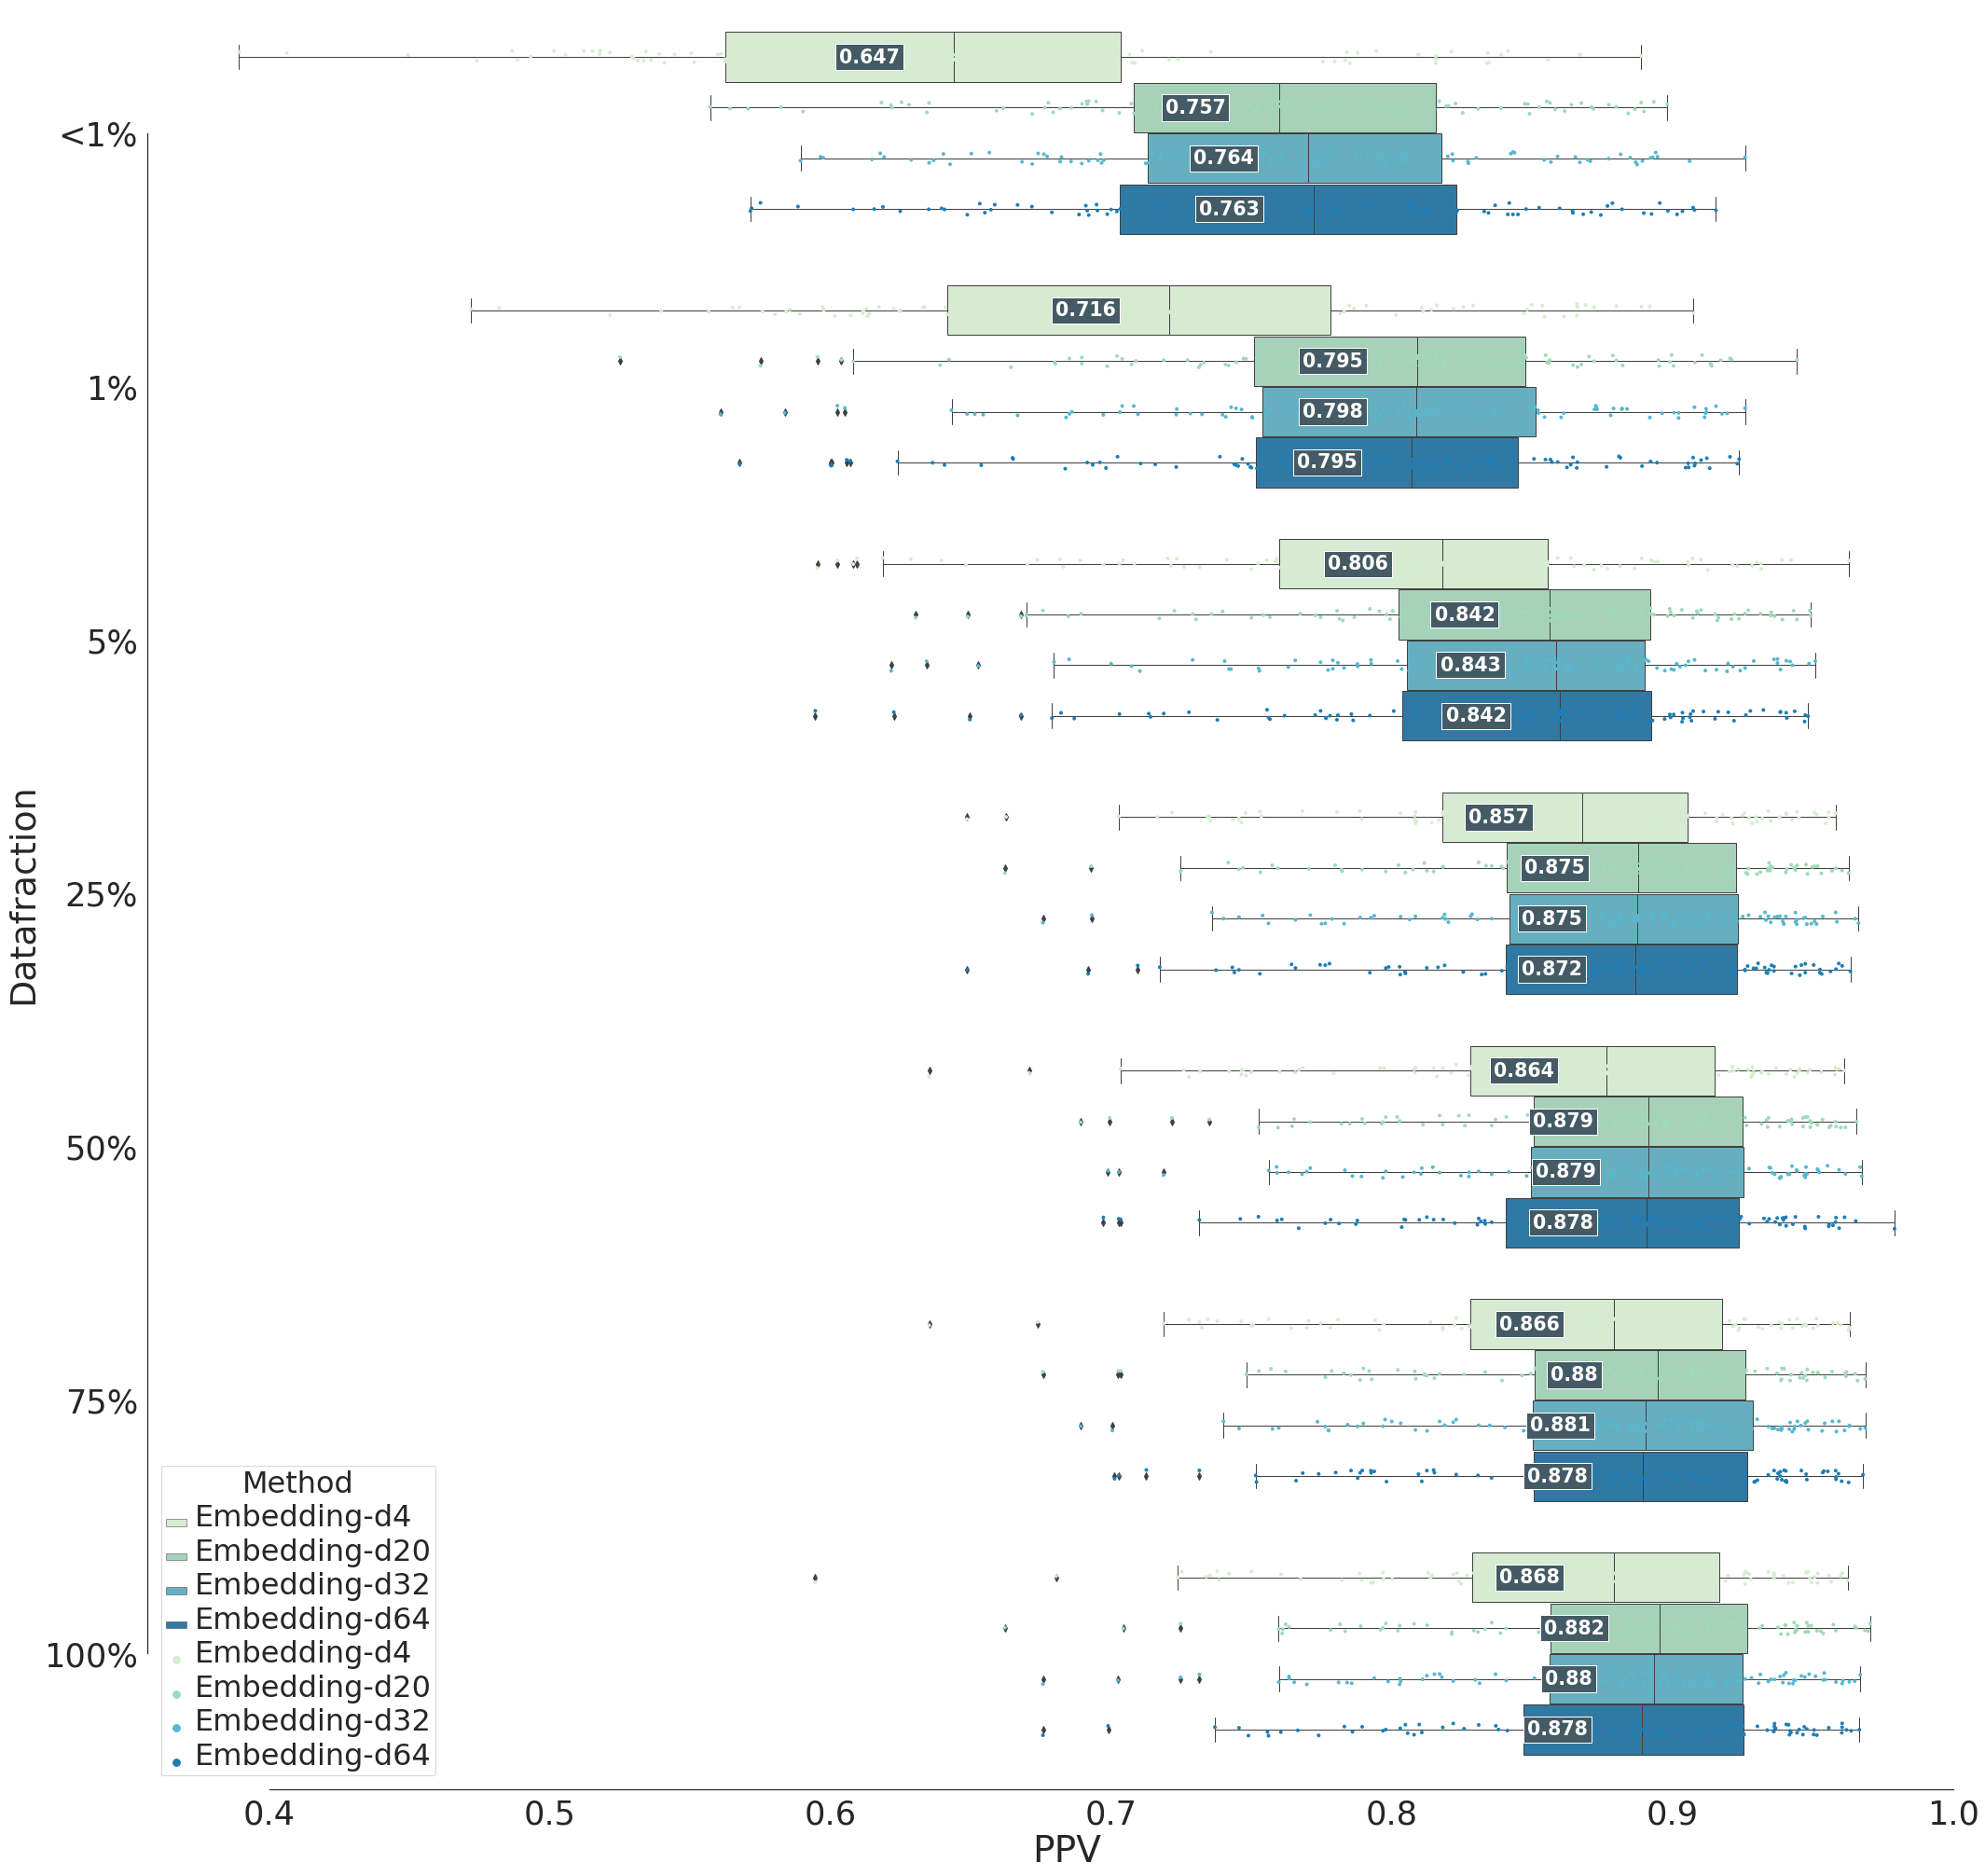

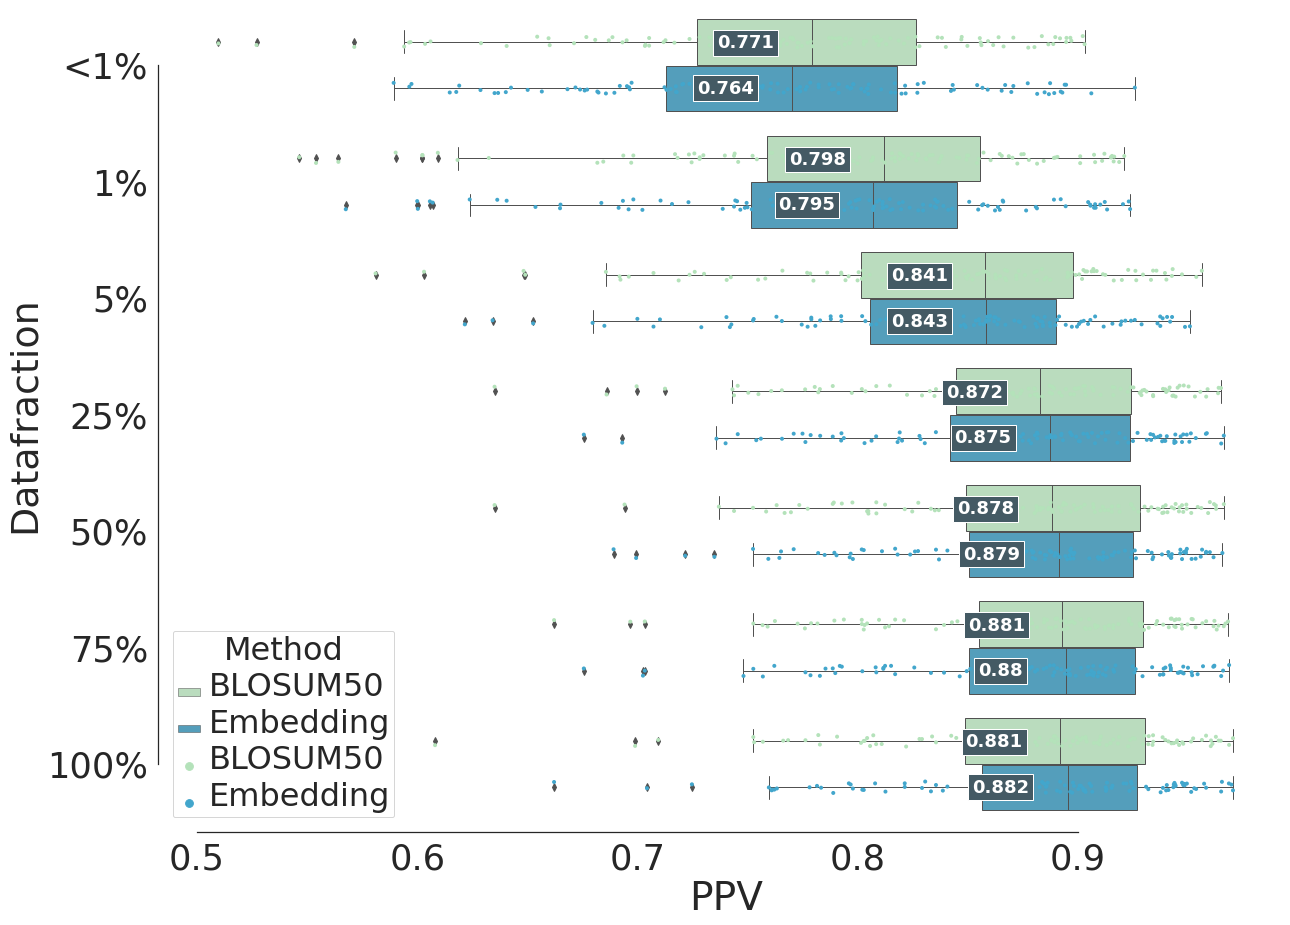

In [25]:
#validate report:
# JUN 17 BOX BASE
#NOPOS BIN

d_model_list = [4, 20, 32, 64]

metric = 'PPV'
print(metric)

merged_list = []
df_list = []
median_list_emb = []
mean_list_emb = []
df_list_emb = []

median_list_bl_emb = []
mean_list_bl_emb = []
df_list_bl_emb = []
df_tag_list = []
bin_list = []
mean_list = []
median_list = []

size_list = ['05p', '1p', '5p', '25p', '50p', '75p', '100p']
for size in size_list:

    id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
    id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')
        
    df_name = '{}_d{}_HLAperf.csv'.format(id_blosum,20)
    #print(df_name[53::])
    temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)#[['HLA','{}'.format(metric)]]
    
    if size == '05p':
        s = '<1%'
    else:
        s = size.replace('p', '%')
    temp_1['Datafraction'] = s
    temp_1['Method'] = 'BLOSUM50'
    
    # ----
    md = np.median(list(temp_1[metric]))
    me = np.mean(list(temp_1[metric]))
    median_list.append(md)
    mean_list.append(me)
    median_list_bl_emb.append(md)
    mean_list_bl_emb.append(me)
    df_list_bl_emb.append(temp_1)
    df_list.append(temp_1)
    # ----
    
    tag_1 = size + '_onlyBlosum' + '_d20'
    #print(tag_1, 'added.')
    
    for d_model in d_model_list:
        
        fi = 'NOPOSCOMP'
        
        id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
        id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
        
        if size in ['75p']:
            fi = 'NOPOS'
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if d_model in [20, 32] and size =='50p':
            fi = 'NOPOS'
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if size =='100p':
            fi = 'PO'
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')
            
        df_name = '{}_d{}_HLAperf.csv'.format(id_emb,d_model)
        #print(df_name[53::])
        temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2['Datafraction'] = s
        temp_2['Method'] = 'Embedding-d{}'.format(d_model)
        
        
        
        df_list.append(temp_2)
        df_list_emb.append(temp_2)
        tag_2 = size + '_onlyEmbedding_d' + str(d_model)
        #print(tag_2, 'added.')
        
        md = np.median(list(temp_2[metric]))
        me = np.mean(list(temp_2[metric]))
        
        # ----
        temp_2_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2_bl_em['Datafraction'] = s
        temp_2_bl_em['Method'] = 'Embedding'.format(d_model)
        
        if size+str(d_model) in ['05p32', '1p64', '5p32', '25p32', '50p20', '75p20', '100p20']: #32 64 32 32 20 20 20
            df_list_bl_emb.append(temp_2_bl_em)
            median_list_bl_emb.append(md)
            mean_list_bl_emb.append(me)
        
        median_list.append(md)
        mean_list.append(me)
        mean_list_emb.append(me)
        median_list_emb.append(md)
        # ----
        
        merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

        blosum_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

        pval = stats.binom_test(blosum_wins, n=112, p=0.5, alternative='greater')
        bin_ = [tag_1+" vs "+tag_2 + '_' + fi, size, 112-blosum_wins, blosum_wins, pval]
        df_temp = pd.DataFrame(bin_, columns = [size])
        #print(bin_)
        merged['type'] = tag_1 + " vs " + tag_2 
        merged_list.append(merged)
        bin_list.append(pd.DataFrame(bin_, columns = [size]))
        
    #print(".")
#print([tag_1+" vs "+tag_2, size, 'emb_wins', 'blosum_wins', pval])


df_concat_o = pd.concat(df_list)

df_concat_o = pd.concat(df_list_emb)
df_concat_o 

m1 = mean_list_emb #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = median_list_emb
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(35,35))

sn.boxplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=32)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=32)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=39)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=38)

sn.set(font_scale=3.2)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.7
for cat in range(7):
    y_add = 0.2
    x_ax_inc += y_add
    for subcat in range(4):
        x_ax_inc += 0.2
        #x_ax_inc_ = round(m1[idx],2)
        #print(x_ax_inc_)
        y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
        y_d = mL1_d[idx]
        y_list.append(y)
        ax.text(
            float(y_d)-0.03,
            x_ax_inc, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=20.5,
            color='white',
            bbox=dict(facecolor='#445A64'))
        
        idx += 1
        
plt.show()

df_concat_o = pd.concat(df_list_bl_emb)
df_concat_o 

m1 = mean_list_bl_emb #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = median_list_bl_emb
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(20,15))

sn.boxplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=32)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=32)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=39)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=38)

sn.set(font_scale=3.2)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.8
for cat in range(7):
    y_add = 0.22
    x_ax_inc += y_add
    for subcat in range(2):
        x_ax_inc += 0.39
        #x_ax_inc_ = round(m1[idx],2)
        #print(x_ax_inc_)
        y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
        y_d = mL1_d[idx]
        y_list.append(y)
        ax.text(
            float(y_d)-0.03,
            x_ax_inc, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=18,
            color='white',
            bbox=dict(facecolor='#445A64'))
        
        idx += 1
        
plt.show()

AUC01


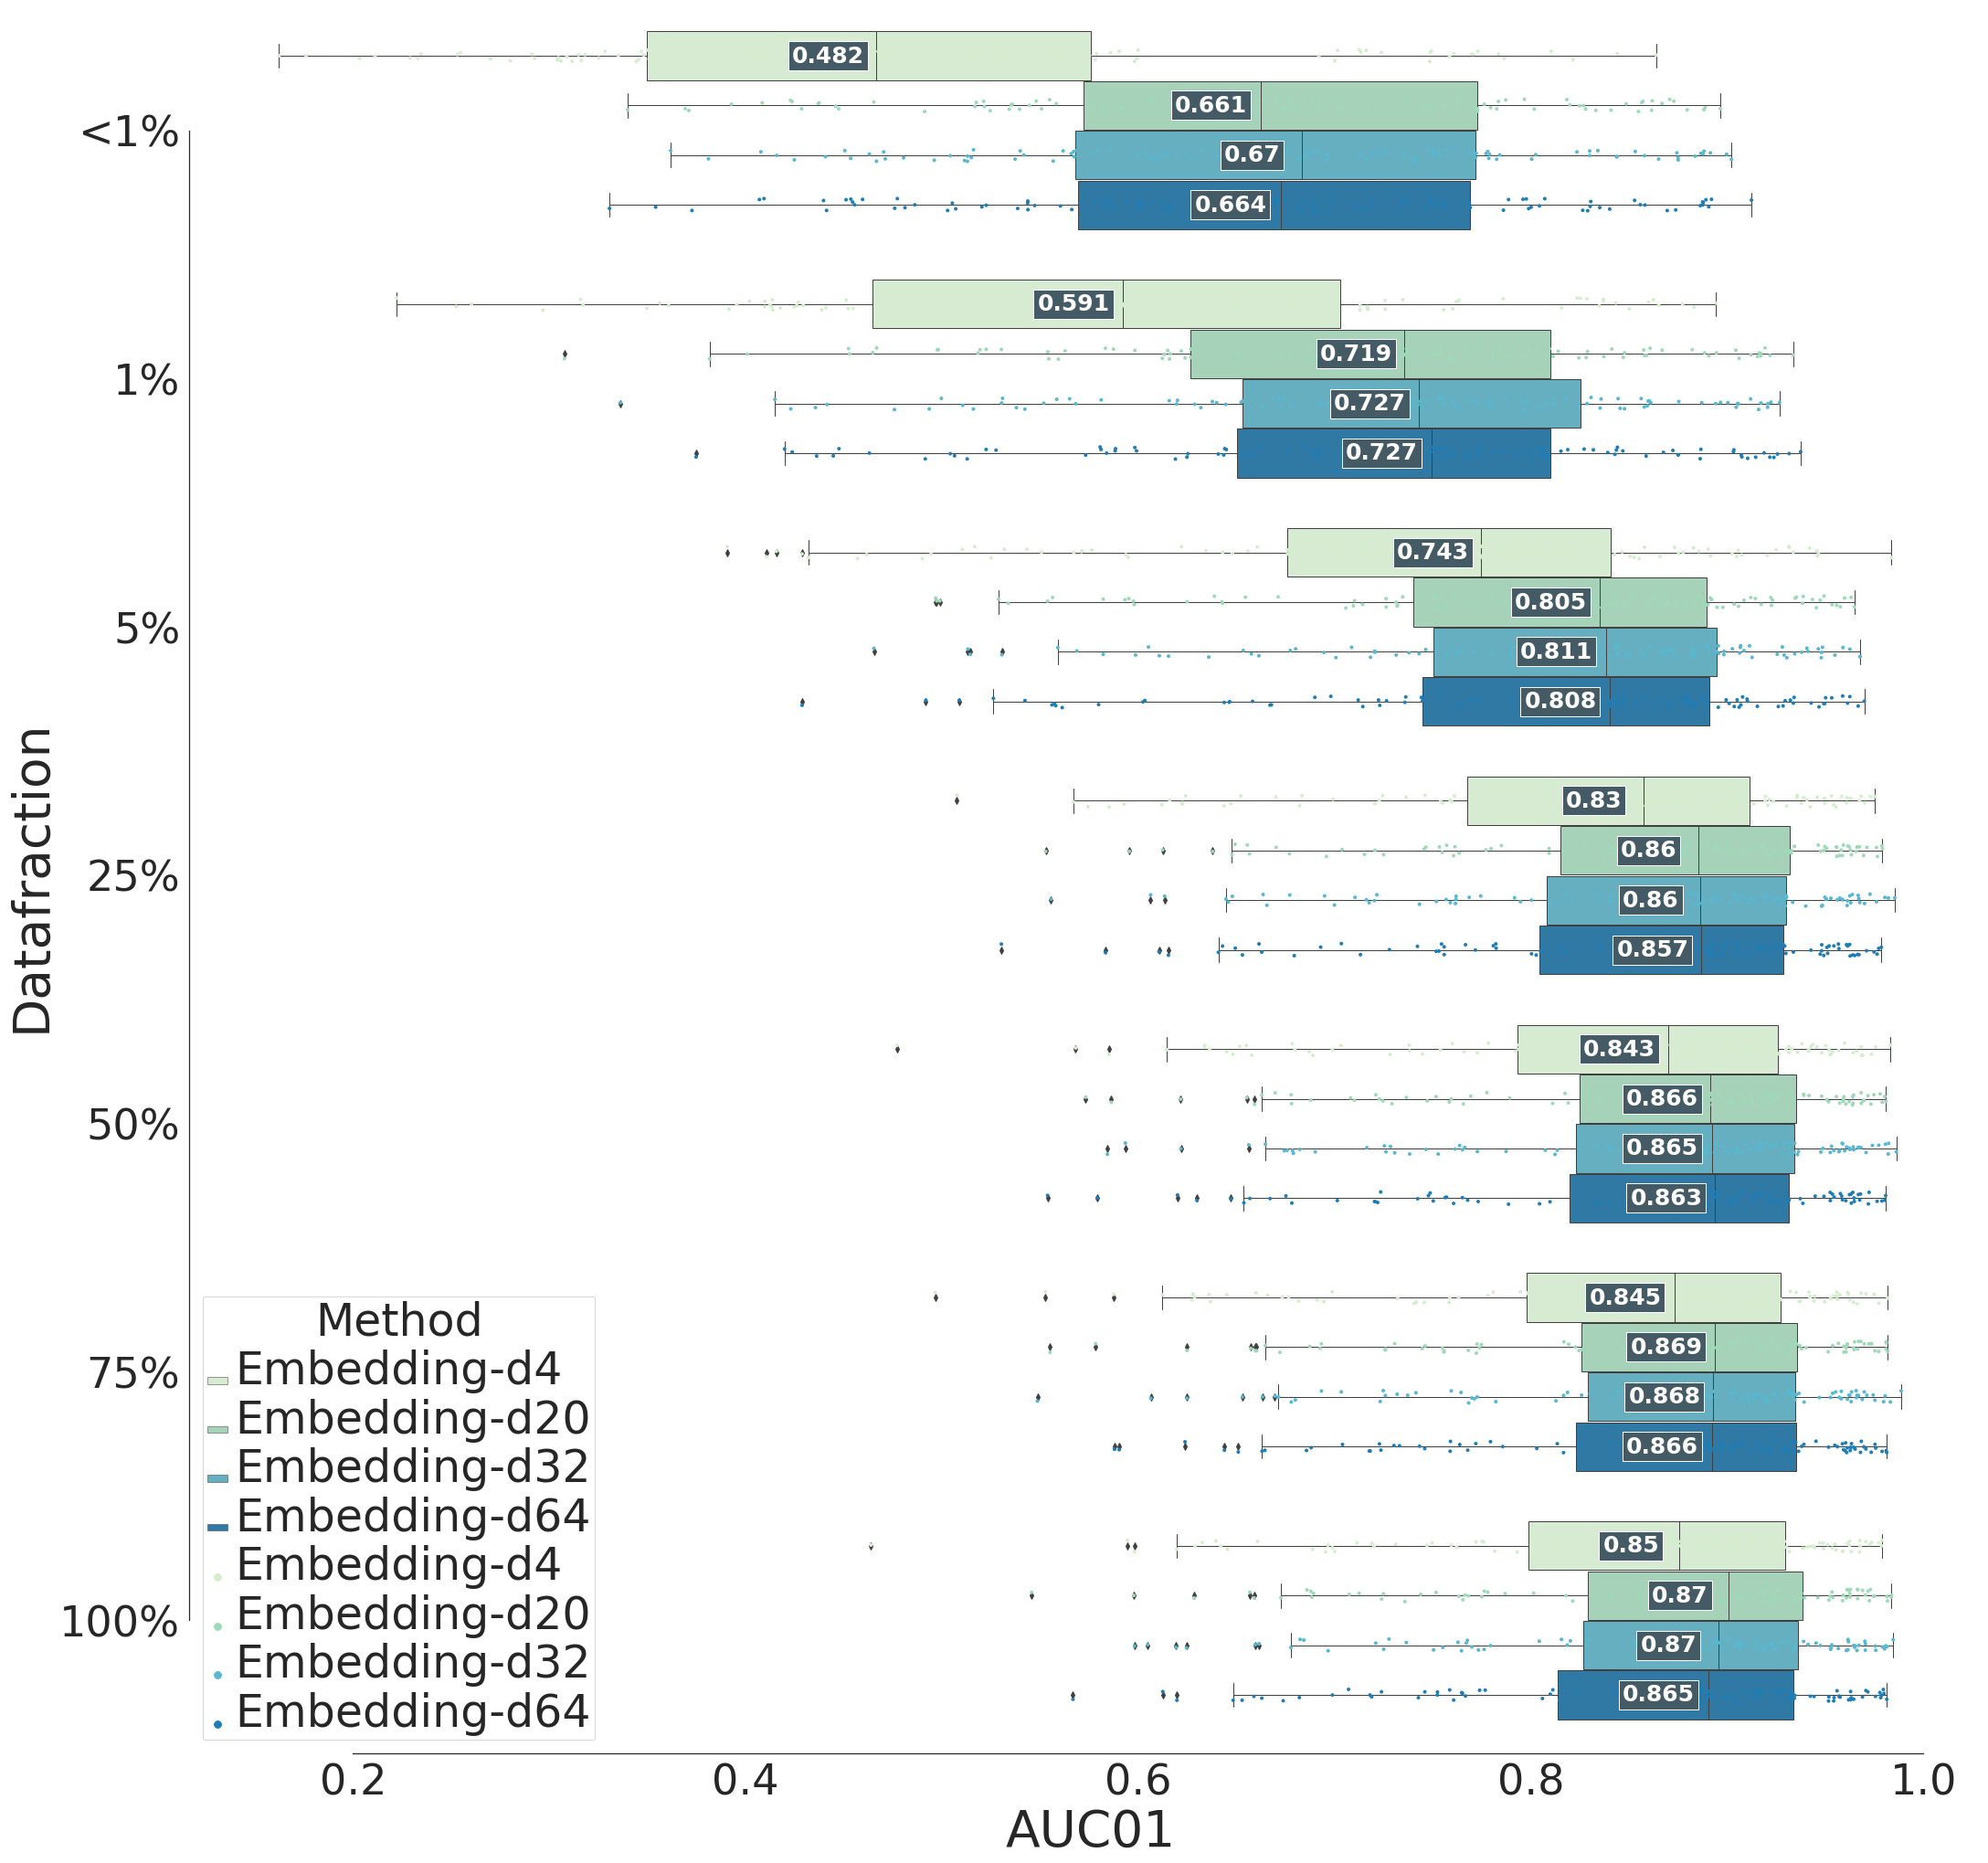

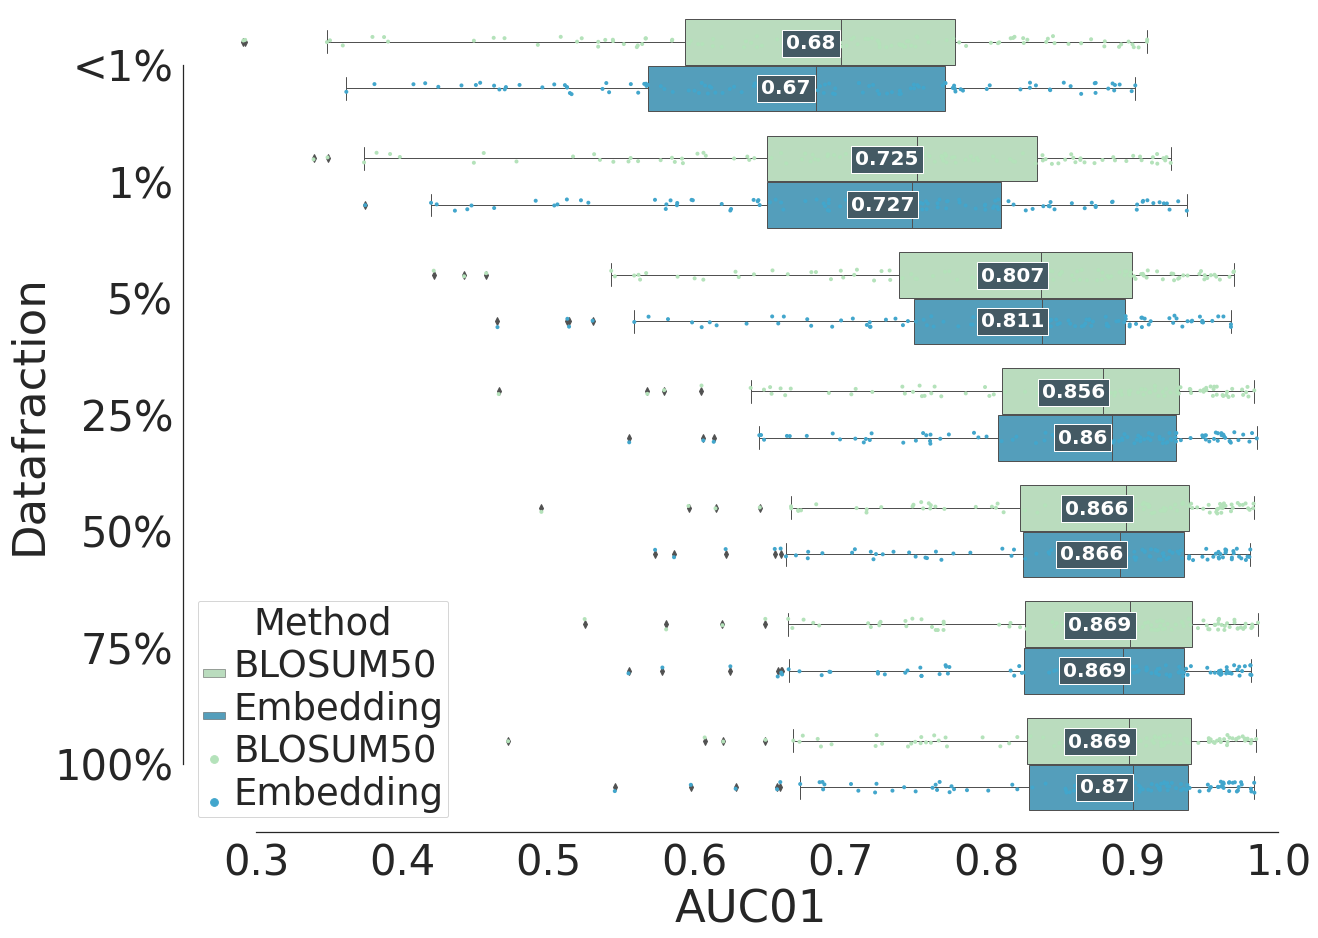

In [35]:
#validate report:
# JUN 17 BOX BASE
#NOPOS BIN

d_model_list = [4, 20, 32, 64]

metric = 'AUC01'
print(metric)

merged_list = []
df_list = []
median_list_emb = []
mean_list_emb = []
df_list_emb = []

median_list_bl_emb = []
mean_list_bl_emb = []
df_list_bl_emb = []
df_tag_list = []
bin_list = []
mean_list = []
median_list = []

size_list = ['05p', '1p', '5p', '25p', '50p', '75p', '100p']
for size in size_list:

    id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
    id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')
        
    df_name = '{}_d{}_HLAperf.csv'.format(id_blosum,20)
    #print(df_name[53::])
    temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)#[['HLA','{}'.format(metric)]]
    
    if size == '05p':
        s = '<1%'
    else:
        s = size.replace('p', '%')
    temp_1['Datafraction'] = s
    temp_1['Method'] = 'BLOSUM50'
    
    # ----
    md = np.median(list(temp_1[metric]))
    me = np.mean(list(temp_1[metric]))
    median_list.append(md)
    mean_list.append(me)
    median_list_bl_emb.append(md)
    mean_list_bl_emb.append(me)
    df_list_bl_emb.append(temp_1)
    df_list.append(temp_1)
    # ----
    
    tag_1 = size + '_onlyBlosum' + '_d20'
    #print(tag_1, 'added.')
    
    for d_model in d_model_list:
        
        fi = 'NOPOSCOMP'
        
        id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
        id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
        
        if size in ['75p']:
            fi = 'NOPOS'
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if d_model in [20, 32] and size =='50p':
            fi = 'NOPOS'
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if size =='100p':
            fi = 'PO'
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')
            
        df_name = '{}_d{}_HLAperf.csv'.format(id_emb,d_model)
        #print(df_name[53::])
        temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2['Datafraction'] = s
        temp_2['Method'] = 'Embedding-d{}'.format(d_model)
        
        
        
        df_list.append(temp_2)
        df_list_emb.append(temp_2)
        tag_2 = size + '_onlyEmbedding_d' + str(d_model)
        #print(tag_2, 'added.')
        
        md = np.median(list(temp_2[metric]))
        me = np.mean(list(temp_2[metric]))
        
        # ----
        temp_2_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2_bl_em['Datafraction'] = s
        temp_2_bl_em['Method'] = 'Embedding'.format(d_model)
        
        if size+str(d_model) in ['05p32', '1p64', '5p32', '25p32', '50p20', '75p20', '100p20']: #32 64 32 32 20 20 20
            df_list_bl_emb.append(temp_2_bl_em)
            median_list_bl_emb.append(md)
            mean_list_bl_emb.append(me)
        
        median_list.append(md)
        mean_list.append(me)
        mean_list_emb.append(me)
        median_list_emb.append(md)
        # ----
        
        merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

        blosum_wins = len(merged[merged['{}_x'.format(metric)] > merged['{}_y'.format(metric)]]['HLA'].tolist())

        pval = stats.binom_test(blosum_wins, n=112, p=0.5, alternative='greater')
        bin_ = [tag_1+" vs "+tag_2 + '_' + fi, size, 112-blosum_wins, blosum_wins, pval]
        df_temp = pd.DataFrame(bin_, columns = [size])
        #print(bin_)
        merged['type'] = tag_1 + " vs " + tag_2 
        merged_list.append(merged)
        bin_list.append(pd.DataFrame(bin_, columns = [size]))
        
    #print(".")
#print([tag_1+" vs "+tag_2, size, 'emb_wins', 'blosum_wins', pval])


df_concat_o = pd.concat(df_list)

df_concat_o = pd.concat(df_list_emb)
df_concat_o 

m1 = mean_list_emb #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = median_list_emb
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(35,35))

sn.boxplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=49)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=49)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=55)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=55)

sn.set(font_scale=4.2)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.7
for cat in range(7):
    y_add = 0.2
    x_ax_inc += y_add
    for subcat in range(4):
        x_ax_inc += 0.2
        #x_ax_inc_ = round(m1[idx],2)
        #print(x_ax_inc_)
        y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
        y_d = mL1_d[idx]
        y_list.append(y)
        ax.text(
            float(y_d)-0.025,
            x_ax_inc, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=25,
            color='white',
            bbox=dict(facecolor='#445A64'))
        
        idx += 1
        
plt.show()

df_concat_o = pd.concat(df_list_bl_emb)
df_concat_o 

m1 = mean_list_bl_emb #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = median_list_bl_emb
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(20,15))

sn.boxplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=37)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=37)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=45)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=45)

sn.set(font_scale=3.8)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.8
for cat in range(7):
    y_add = 0.22
    x_ax_inc += y_add
    for subcat in range(2):
        x_ax_inc += 0.39
        #x_ax_inc_ = round(m1[idx],2)
        #print(x_ax_inc_)
        y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
        y_d = mL1_d[idx]
        y_list.append(y)
        ax.text(
            float(y_d)-0.02,
            x_ax_inc, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=20,
            color='white',
            bbox=dict(facecolor='#445A64'))
        
        idx += 1
        
plt.show()

## SEE THE CONSERVANCY OF MCH PSEUDO SEQUENCES

In [129]:
from collections import Counter

for p in range(34):
    pos_aa = [i[p] for i in list(df_temp_HLA.HLA_sequence)]
    cc = res = Counter(pos_aa)
    ss = set(pos_aa)
    if len(ss) > 5:
        mark = '!!!!'
    if len(ss) == 1:
        mark = '--C--'
    else:
        mark = ''
    print("pos:",p+1, '||', ss, '||', cc, mark)
    print('')
    
    
    #1,5,14, 24,31,34


pos: 1 || {'Y'} || Counter({'Y': 112}) --C--

pos: 2 || {'Y', 'S', 'H', 'F', 'D', 'T'} || Counter({'Y': 55, 'H': 21, 'F': 18, 'S': 10, 'D': 5, 'T': 3}) 

pos: 3 || {'T', 'A', 'S'} || Counter({'A': 69, 'T': 22, 'S': 21}) 

pos: 4 || {'K', 'G', 'E', 'T', 'M'} || Counter({'M': 49, 'E': 25, 'G': 17, 'T': 11, 'K': 10}) 

pos: 5 || {'Y', 'H'} || Counter({'Y': 111, 'H': 1}) 

pos: 6 || {'Q', 'G', 'R', 'E', 'L'} || Counter({'R': 80, 'G': 17, 'Q': 8, 'E': 6, 'L': 1}) 

pos: 7 || {'Q', 'N', 'E'} || Counter({'E': 76, 'N': 35, 'Q': 1}) 

pos: 8 || {'K', 'N', 'I'} || Counter({'I': 51, 'K': 33, 'N': 28}) 

pos: 9 || {'Y', 'S', 'V', 'C', 'F', 'M'} || Counter({'V': 39, 'Y': 23, 'S': 19, 'C': 19, 'F': 7, 'M': 5}) 

pos: 10 || {'R', 'T', 'A'} || Counter({'A': 60, 'T': 35, 'R': 17}) 

pos: 11 || {'Q', 'K', 'S', 'H', 'N'} || Counter({'N': 35, 'Q': 31, 'H': 31, 'K': 11, 'S': 4}) 

pos: 12 || {'T', 'A', 'I'} || Counter({'T': 102, 'A': 7, 'I': 3}) 

pos: 13 || {'D', 'Y', 'H', 'N'} || Counter({'D': 64, 'Y': 3